In [1]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device ,torch.cuda.is_available())

cuda True


In [2]:
torch.cuda.is_available()

True

In [3]:
import sys,os, pickle

import torch.nn as nn
from transformers import BertModel, BertTokenizer
from transformers import BertForMaskedLM
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, random_split
from transformers import AdamW
from tqdm import tqdm  # for our progress bar

from sklearn.metrics import precision_recall_fscore_support , accuracy_score,f1_score
import numpy as np
from transformers import AutoModelForSequenceClassification

import random


EXPERIMENT_NAME="TYPE_WRITER_BERT_final_O1"

BATCH_SIZE = 30
MAX_TOKEN_SIZE = 512


In [4]:
def fix_types(type_name):
    global TYPE_FIX_MAP
    
    prev_type_name= type_name
    
    if '*' in type_name:
        if type_name.rindex('*')>0:#reduce to single * (rightmost, ignore array before that)
            type_name = type_name[ type_name.rindex('*'): ]
    if 'array_' in type_name:
        if type_name.rindex('array_')>0:
            type_name = type_name[ type_name.rindex('array_'): ]
    if 'unsigned char' in type_name:
        type_name = type_name.replace('unsigned char' , 'char')
        
        
    if type_name not in TYPE_FIX_MAP:
        TYPE_FIX_MAP[prev_type_name] = type_name
    return type_name



In [5]:
# DATA_PATH = '/media/raisul/nahid_personal/no_address/instructions_and_type_data_100k/'
DATA_PATH ='/media/raisul/nahid_personal/optimizations/O1_mix/instructions_and_type_data_100k/'
SURPLUS_DATA_PATHS = []# ['/home/raisul/type_data/instructions_and_type_data_100k']
MODEL_SAVE_PATH =  '/home/raisul/models/'
TYPE_COUNT ={}
FINAL_TYPE_COUNT = {}
TYPE_PROBABILITY = {}


REJECT = ['union' , 'enumeration' , 'int128' , '_Bool' , 'complex' ,'bool']
TYPE_FIX_MAP = {}
MAX_TYPE_SAMPLE  =20*1000
TYPE_MAPPING = {}


ALL_INPUT_LIST = []
ALL_INPUT_SLICE_INFO  = []
ALL_LABEL_LIST = []



In [6]:

#TODO dont load all at a time in memry
def make_dataset():
    global TYPE_FIX_MAP, REJECT ,TYPE_COUNT,TYPE_MAPPING
    
    
    
    #count how many real samples
    for fi,pkl_file_name in enumerate(os.listdir(DATA_PATH)):
#         if fi>10:
#             break
        pkl_path = os.path.join(DATA_PATH,pkl_file_name)
        with open(pkl_path, 'rb') as file:
            try:
                model_input_list, model_type_list = pickle.load(file)

            except Exception as e:
                pass
            for i in range(len(model_input_list)):

                type_str = fix_types(model_type_list[i])
                
                if type_str not in TYPE_COUNT:
                    TYPE_COUNT[type_str] = 0
                    FINAL_TYPE_COUNT[type_str] = 0
                
                TYPE_COUNT[type_str] +=1
#         if fi>100:
#             break
    print(TYPE_COUNT)
    
    #remove the unwanted types
    temp_removed_keys = []
    for rk in REJECT:
        for tk in TYPE_COUNT:
            if rk in tk:
                temp_removed_keys.append(tk)
        for tfm in TYPE_FIX_MAP:
            if tfm in tk:
                temp_removed_keys.append(tk)
    print('temp_removed_keys',temp_removed_keys)
    for trk in temp_removed_keys:
        if trk in TYPE_COUNT:
            TYPE_COUNT.pop(trk)
        if trk in FINAL_TYPE_COUNT:
            FINAL_TYPE_COUNT.pop(trk)
        if trk in TYPE_FIX_MAP:
            TYPE_FIX_MAP.pop(trk)
    
    TYPE_COUNT = {k: v for k, v in sorted(TYPE_COUNT.items(), key=lambda item: item[1] , reverse=True)}


    ti = 0
    for key,val in TYPE_COUNT.items():
        TYPE_MAPPING[key]  = ti
        ti+=1

    #make the probability
    for key in TYPE_COUNT.keys():
        print(MAX_TYPE_SAMPLE , TYPE_COUNT[key] ,key)
        TYPE_PROBABILITY[key] = MAX_TYPE_SAMPLE/TYPE_COUNT[key]
    

    print(TYPE_PROBABILITY)
    
    
    ######################################
    #######################################
    
    ALL_DATA_FILES = []
    for pkl_file_name in os.listdir(DATA_PATH):
        ALL_DATA_FILES.append( [os.path.join(DATA_PATH,pkl_file_name) , pkl_file_name , 1]   )
        
    for surplus_data_path in SURPLUS_DATA_PATHS:
        for surplus_pkl_file_name in (os.listdir(surplus_data_path)):
            ALL_DATA_FILES.append( [os.path.join(surplus_data_path,surplus_pkl_file_name) , surplus_pkl_file_name , 0   ])
    
    #fill dataset with that probability
    for fi,data_info in enumerate(ALL_DATA_FILES):
#         if fi>1000:
#             break
        pkl_path, pkl_file_name , _= data_info
        
        training = True
        
        if sum(bytearray(pkl_file_name.rsplit('_____', 1)[0],'utf-8') )%10>=8:  # tag bins as train/val accrding to the name
                                                                             # (for optimization variations)
            training = False
        
        with open(pkl_path, 'rb') as file:
            try:
                model_input_list, model_type_list = pickle.load(file)
            except Exception as e:
                pass
            for i in range(len(model_input_list)):
                
                try:
                    type_str = TYPE_FIX_MAP[model_type_list[i]]
                    type_label = TYPE_MAPPING[type_str]

                    backward_slice , target_slice, forward_slice = model_input_list[i]

                    if random.random()<=TYPE_PROBABILITY[type_str]:

                        ALL_INPUT_LIST.append(backward_slice + target_slice + forward_slice)
                        ALL_INPUT_SLICE_INFO.append([len(backward_slice) , len(target_slice) , len(forward_slice)])
                        ALL_LABEL_LIST.append(type_label)



                        FINAL_TYPE_COUNT[type_str]+=1
                except:
                      pass

make_dataset()

{'array_int': 699412, 'int': 1086557, 'array_signed char': 744067, 'unsigned long int': 61180, '*structure': 46397, '*signed char': 66656, 'signed char': 75978, 'double': 34500, 'array_float': 28976, 'float': 61767, 'structure': 487533, '*int': 34705, 'array_double': 20820, '*float': 1166, 'long long int': 9063, 'unsigned int': 19815, '*double': 969, 'long int': 16431, 'array_long long int': 5094, '*void': 63856, 'short int': 2631, 'array_char': 28453, 'array_unsigned long int': 663, 'array_long int': 6839, '*long int': 294, 'char': 8223, '*char': 960, '*unsigned long int': 567, 'unsigned short int': 1330, 'array_unsigned int': 16907, 'unsigned long long int': 1070, '*unsigned int': 1279, 'long double': 325, 'array_unsigned short int': 1087, 'array_long double': 40, 'array_unsigned long long int': 3050, 'array_short int': 2439, '*short int': 1045, '*long long int': 2082, '*unsigned short int': 184, '*unsigned long long int': 276}
temp_removed_keys ['*unsigned long long int', '*unsigned

In [7]:
data_temp_path = 'data/typedata'+EXPERIMENT_NAME+'.ignore.pkl'
with open(data_temp_path, 'wb') as f:
    pickle.dump([TYPE_COUNT , TYPE_MAPPING ,ALL_INPUT_LIST, ALL_INPUT_SLICE_INFO ,ALL_LABEL_LIST,   FINAL_TYPE_COUNT ], f)
    
    
with open(data_temp_path, 'rb') as file:
    TYPE_COUNT , TYPE_MAPPING ,ALL_INPUT_LIST, ALL_INPUT_SLICE_INFO ,ALL_LABEL_LIST,     FINAL_TYPE_COUNT  = pickle.load(file)    

In [8]:

print(len(ALL_INPUT_LIST), FINAL_TYPE_COUNT)

402829 {'array_int': 20439, 'int': 20014, 'array_signed char': 20025, 'unsigned long int': 19911, '*structure': 20080, '*signed char': 19968, 'signed char': 19886, 'double': 19795, 'array_float': 19955, 'float': 20065, 'structure': 19838, '*int': 19702, 'array_double': 20043, '*float': 1165, 'long long int': 9054, 'unsigned int': 19804, '*double': 969, 'long int': 16416, 'array_long long int': 5094, '*void': 20007, 'short int': 2626, 'array_char': 19989, 'array_unsigned long int': 663, 'array_long int': 6839, '*long int': 294, 'char': 8211, '*char': 960, '*unsigned long int': 567, 'unsigned short int': 1323, 'array_unsigned int': 16833, 'unsigned long long int': 1068, '*unsigned int': 1279, 'long double': 71, 'array_unsigned short int': 1076, 'array_long double': 0, 'array_unsigned long long int': 3050, 'array_short int': 2439, '*short int': 1045, '*long long int': 2082, '*unsigned short int': 184}


In [9]:
tokenizer  = BertTokenizer.from_pretrained("./multytask-tokenizer_optim_3_d4")

#https://github.com/huggingface/tokenizers/issues/247

mask_token_id, look_token_id, eoi_token_id = tokenizer.encode('[MASK] [LOOK] [EOI]')[1:-1]

print(mask_token_id, look_token_id, eoi_token_id)

4 6 5


In [10]:

VOCAB_SIZE = tokenizer.vocab_size

print('VOCAB SIZE : ', (tokenizer.vocab_size))

VOCAB SIZE :  3000


In [11]:
# Create model instance
#TODO*** USE PRETRAINED
# PATH, local_files_only=True #/home/raisul/models/pretrain_100k #bert-base-uncased
model = AutoModelForSequenceClassification.from_pretrained("/home/raisul/models/pretrain_100k_O2", num_labels=len(TYPE_MAPPING.items()))
model.to(device)


print(model.config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/raisul/models/pretrain_100k_O2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "/home/raisul/models/pretrain_100k_O2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31

In [12]:

# Tokenize input text
# inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
# inputs = tokenizer(ALL_INPUT_LIST, max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')
# print(inputs.keys())

# labels = ALL_LABEL_LIST.to(device)

In [13]:
# print(inputs.keys())
# print(inputs.token_type_ids)
# inputs.token_type_ids[0][0] =1
# print(inputs.token_type_ids)
# #TODO set token type ids

In [14]:
# class BinaryDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings):
#         self.encodings = encodings
#     def __getitem__(self, idx):
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#     def __len__(self):
#         return len(self.encodings.input_ids)

In [15]:
class BinaryDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text
        tokenized_text = (self.tokenizer(text , max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')).to(device)
        
        # Convert tokens to input IDs
#         input_ids = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        
        # Create input tensors
#         input_ids = tokenized_text['input_ids']  #torch.tensor(input_ids)
        label = torch.tensor([label]).to(device)
        
        return tokenized_text, label
        
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.texts)

In [16]:

dataset = BinaryDataset(ALL_INPUT_LIST, ALL_LABEL_LIST,tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])



train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE ,shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [17]:
dataset_path = 'data/typedata_dataset'+EXPERIMENT_NAME+'.ignore.pkl'
with open(dataset_path, 'wb') as f:
    pickle.dump([train_dataset, validation_dataset], f)
    
    
with open(dataset_path, 'rb') as file:
    train_dataset, validation_dataset  = pickle.load(file)    

In [18]:

train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE ,shuffle=True) 
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
# global_task2_metrices, global_task1_metrices ,v_global_task1_metrices, v_global_task2_metrices

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(task1_metrices,   v_task1_metrices, label = "TypeGraph" ):
    
    plt.ioff()

    font_size = 10
    x_labels = [ i for i in range(len(task1_metrices)) ]
    
    task1_f1 = [ i['f1'] for i in task1_metrices ]

    
    v_task1_f1 = [ i['f1'] for i in v_task1_metrices ]

    

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, task1_f1 , 'r') 

    
    plt.plot(x_labels, v_task1_f1 , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val' ], loc='upper left')
    
    plt.savefig('./output/'+label+'_f1.pdf')
    plt.close()
    plt.show()
    
    ################################
    ################# LOSS #########
    ################################
    
    task1_loss = [ i['loss'] for i in task1_metrices ]

    
    v_task1_loss = [ i['loss'] for i in v_task1_metrices ]
    

    plt.ylabel(' LOSS ',fontsize=font_size)
    plt.plot(x_labels, task1_loss , 'r') 
    
    plt.plot(x_labels, v_task1_loss , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val'], loc='upper left')
    
    plt.savefig('./output/'+label+'_loss.pdf')
    plt.close()
    plt.show()
    
    

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, label='confusion_matrix'):

    class_labels = list(TYPE_MAPPING.keys())  
    class_labels = [c for c in class_labels]

    cm = confusion_matrix(true_labels, predicted_labels ) 
    
    conf_per_class = cm.diagonal()/cm.sum(axis=1)
    average_acc = sum([i for i in conf_per_class  if not math.isnan(i)] )/len(conf_per_class)
    
    print('CONFUSION PER CLASS' , conf_per_class,average_acc)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    res = sns.heatmap(cm,
            annot=True , cmap="Blues" , fmt='g' , xticklabels=class_labels,linewidths = .01,
                      yticklabels=class_labels,linecolor="Gray")
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    
    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.savefig('./output/'+label+'_conf.pdf',dpi=200)
    plt.show()
    plt.close()
    
    f1_score_per_class = f1_score(true_labels, predicted_labels, average=None)
    print(f1_score_per_class,class_labels)
    f1_scores_with_labels = {label:score for label,score in zip(class_labels, f1_score_per_class)}
    print(f1_scores_with_labels)
# plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)

In [21]:
  #--optimizer adam --adam-betas '(0.9,0.98)' --adam-eps 1e-6 --clip-norm 0.0 \
 # --lr-scheduler polynomial_decay --lr $PEAK_LR --warmup-updates $WARMUP_UPDATES --total-num-update $TOTAL_UPDATES \
  #--dropout 0.1 --attention-dropout 0.1 --weight-decay 0.01 \

#     ( params: typing.Iterable[torch.nn.parameter.Parameter]lr: float = 0.001betas: typing.Tuple[float, 
# float] = (0.9, 0.999)eps: float = 1e-06weight_decay: float = 0.0correct_bias: bool = Trueno_deprecation_warning: bool = False )
    
# initialize optimizer
optim = AdamW( model.parameters() , lr=1e-5, eps = 1e-6, betas=(0.9,0.98), weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
def training_loop(model ,data_loop, is_training = False):
    
    prediction_s, ground_truth_s = [], []
    losses = []

    for N,batch in enumerate(data_loop):
        
        
        # Forward pass
        if is_training == True:
            optim.zero_grad()
        
        batch_input, batch_labels = batch
        if len(batch_labels)<BATCH_SIZE:
            continue
        batch_input_ids= batch_input['input_ids']
        batch_attention_mask=batch_input['attention_mask']
        batch_token_type_ids =batch_input['token_type_ids']

        outputs = model(input_ids=batch_input_ids.squeeze(),
                        attention_mask=batch_attention_mask.squeeze(),
                        token_type_ids=batch_token_type_ids.squeeze(),
                        labels=batch_labels )
        
#

        loss = outputs.loss
        losses.append(loss.item())
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        


        prediction_s.extend(predictions.detach().cpu().numpy().flatten())
        ground_truth_s.extend(batch_labels.detach().cpu().numpy().flatten())


        if is_training == True:
            loss.backward()
            optim.step()


        # print relevant info to progress bar
        data_loop.set_description(f'Epoch {ecpoch}')
        data_loop.set_postfix(loss=loss.item())

    ###### Training Scores
    accuracy = accuracy_score(ground_truth_s, prediction_s)    
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth_s,prediction_s,average='weighted')
    metrices = {'accuracy':accuracy ,
                      'precision':precision, 
                      'recall':recall, 
                      'f1':f1,
                      'loss': (sum(losses) / len(losses))}
    


    return metrices , prediction_s, ground_truth_s
    

Epoch 0: 100%|███████| 10743/10743 [1:16:24<00:00,  2.34it/s, loss=0.967]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training metrices:  {'accuracy': 0.6077763296716937, 'precision': 0.6077887043200779, 'recall': 0.6077763296716937, 'f1': 0.5982151390332245, 'loss': 1.3663958292326166}


Epoch 0: 100%|███████████| 2686/2686 [08:26<00:00,  5.30it/s, loss=0.836]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CONFUSION PER CLASS [0.73076923 0.72081593 0.76505724 0.43103448 0.90718486 0.71418111
 0.96039604 0.92561576 0.86010101 0.76790185 0.79559014 0.90515723
 0.90875553 0.70397202 0.90823828 0.81915158 0.79380841 0.58665034
 0.59978308 0.74676525 0.64922623 0.80918367 0.81967213 0.77263969
 0.65524194 0.59452736 0.56153846 0.125      0.44897959 0.36051502
 0.05957447 0.25238095 0.14096916 0.21505376 0.2734375  0.39166667
 0.         0.         0.        ] 0.5815522050204226


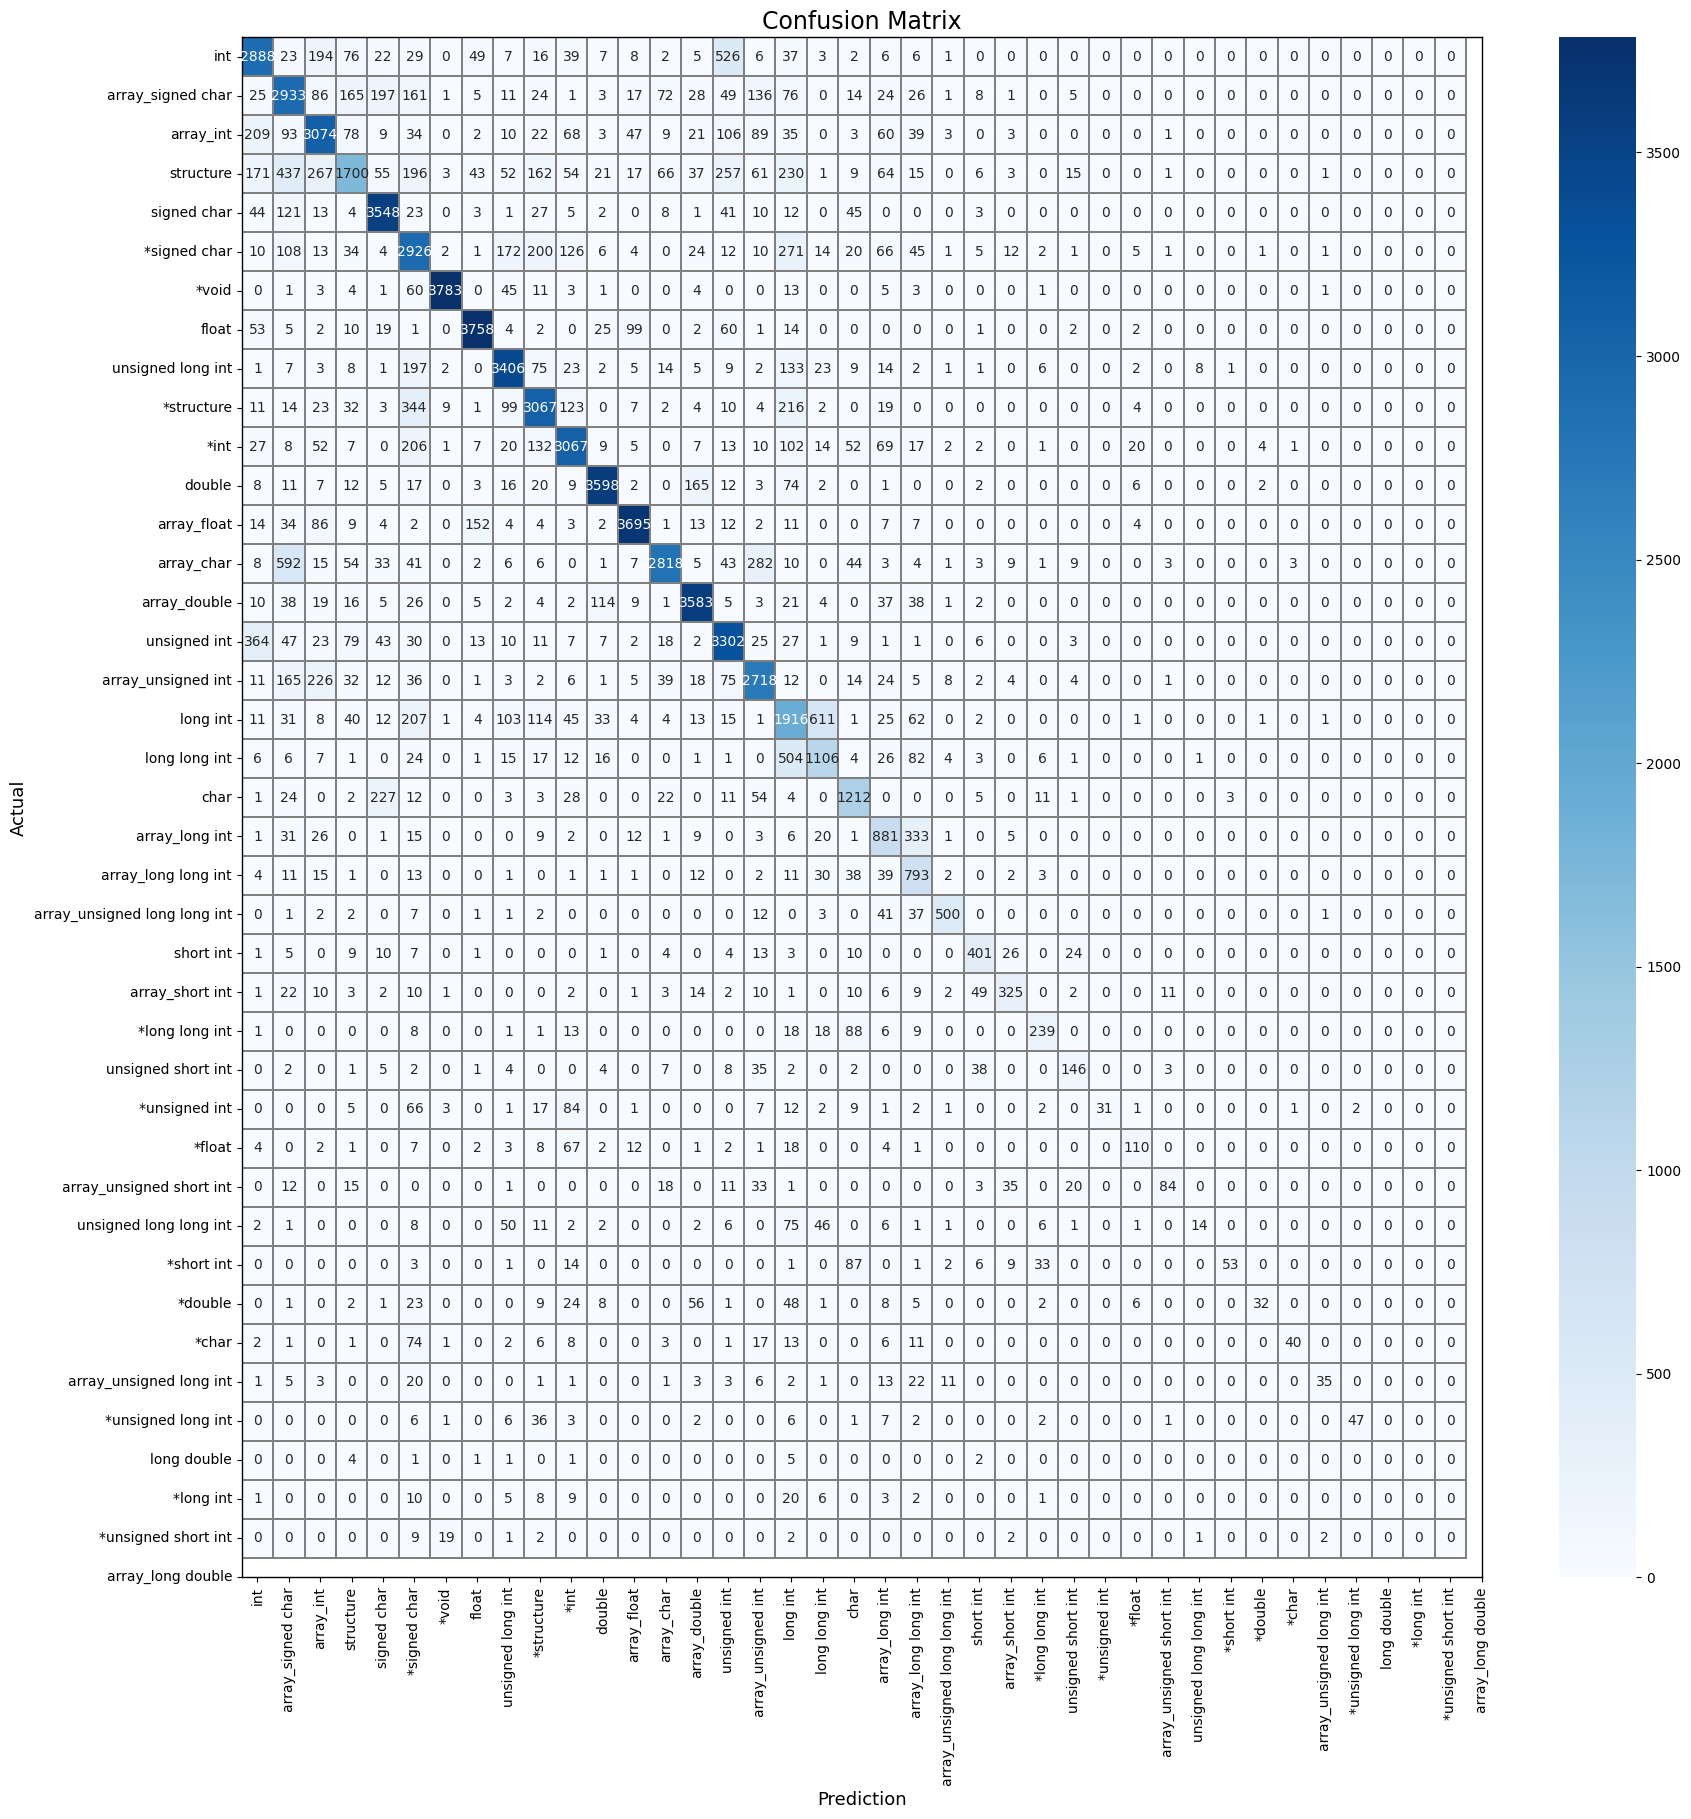

[0.7365468  0.66215148 0.7500305  0.53534876 0.87281673 0.65327082
 0.97424672 0.92607196 0.84863585 0.76455191 0.79589983 0.91738909
 0.92075754 0.79201799 0.89776998 0.76541493 0.77879656 0.53016049
 0.58955224 0.73299063 0.62283492 0.61953125 0.86730269 0.75023386
 0.69742489 0.66573816 0.59109312 0.22222222 0.54054054 0.49557522
 0.10810811 0.39700375 0.23970037 0.34632035 0.41176471 0.55621302
 0.         0.         0.        ] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 1: 100%|████████| 10743/10743 [1:25:31<00:00,  2.09it/s, loss=1.09]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training metrices:  {'accuracy': 0.7995035064854465, 'precision': 0.8002758899556865, 'recall': 0.7995035064854465, 'f1': 0.7980817781029031, 'loss': 0.6690606589506589}


Epoch 1: 100%|███████████| 2686/2686 [08:38<00:00,  5.18it/s, loss=0.482]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CONFUSION PER CLASS [0.82004556 0.74852507 0.80249066 0.49404007 0.95063939 0.80063446
 0.96928934 0.96330953 0.91439394 0.89130979 0.83761349 0.92830189
 0.9429555  0.88433675 0.94903651 0.86061508 0.83737226 0.5681053
 0.67913279 0.83425755 0.820059   0.8470948  0.90491803 0.87283237
 0.80040323 0.92537313 0.79615385 0.60240964 0.5755102  0.72103004
 0.35319149 0.91428571 0.50660793 0.42473118 0.609375   0.81666667
 0.         0.         0.44736842] 0.7337029643366398


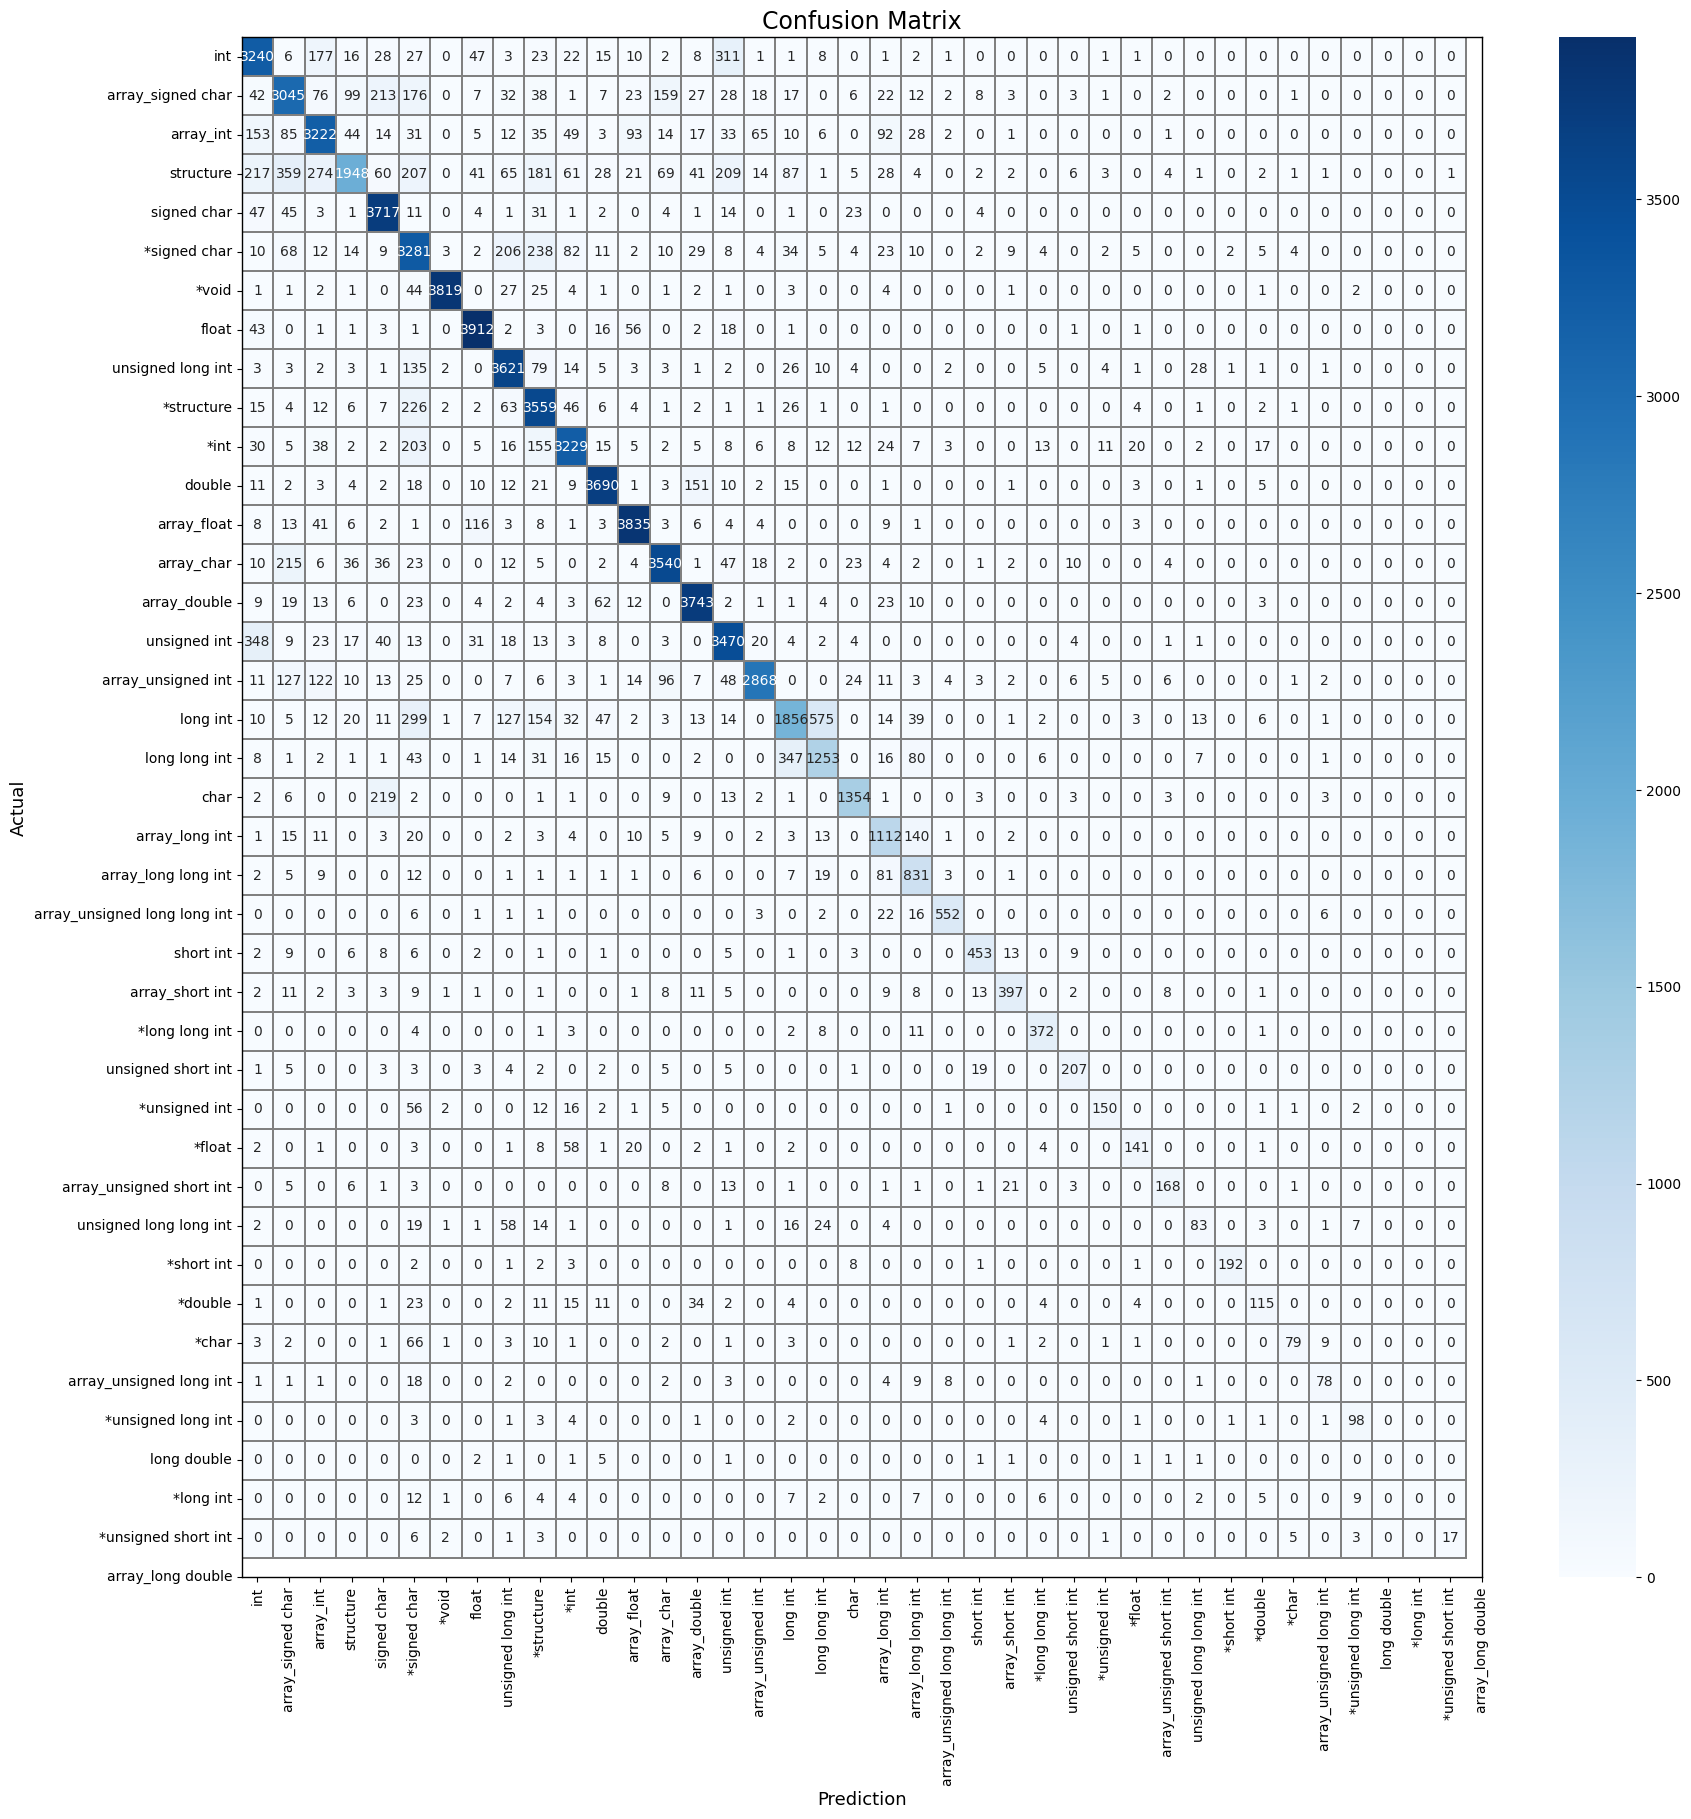

[0.79159541 0.74824917 0.79752475 0.62909737 0.89480019 0.71653199
 0.98237942 0.94664247 0.87389888 0.82004608 0.85615803 0.93005671
 0.93708002 0.88944724 0.92820831 0.83513839 0.88875116 0.64500434
 0.66121372 0.8752424  0.77680754 0.75476839 0.92851135 0.87961165
 0.83228512 0.90291262 0.80544747 0.70093458 0.64827586 0.77958237
 0.44148936 0.94581281 0.57934509 0.56428571 0.67241379 0.81327801
 0.         0.         0.60714286] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 2: 100%|███████| 10743/10743 [1:17:37<00:00,  2.31it/s, loss=0.425]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training metrices:  {'accuracy': 0.8562496121144417, 'precision': 0.8567532254908399, 'recall': 0.8562496121144417, 'f1': 0.8556083338088384, 'loss': 0.47401310839424793}


Epoch 2: 100%|███████████| 2686/2686 [08:24<00:00,  5.32it/s, loss=0.529]


CONFUSION PER CLASS [0.83476721 0.77346437 0.8500996  0.5826572  0.94143223 0.78379697
 0.9741051  0.96403055 0.89724817 0.88382574 0.9151751  0.96051308
 0.91564191 0.94902549 0.94803549 0.90451389 0.9301578  0.64309764
 0.85582656 0.94577942 0.87094395 0.91233435 0.95081967 0.92664093
 0.9233871  0.97263682 0.8        0.79919679 0.63265306 0.89270386
 0.57021277 0.99047619 0.59471366 0.62365591 0.7265625  0.83333333
 0.13333333 0.04615385 0.76315789] 0.8055412686509653


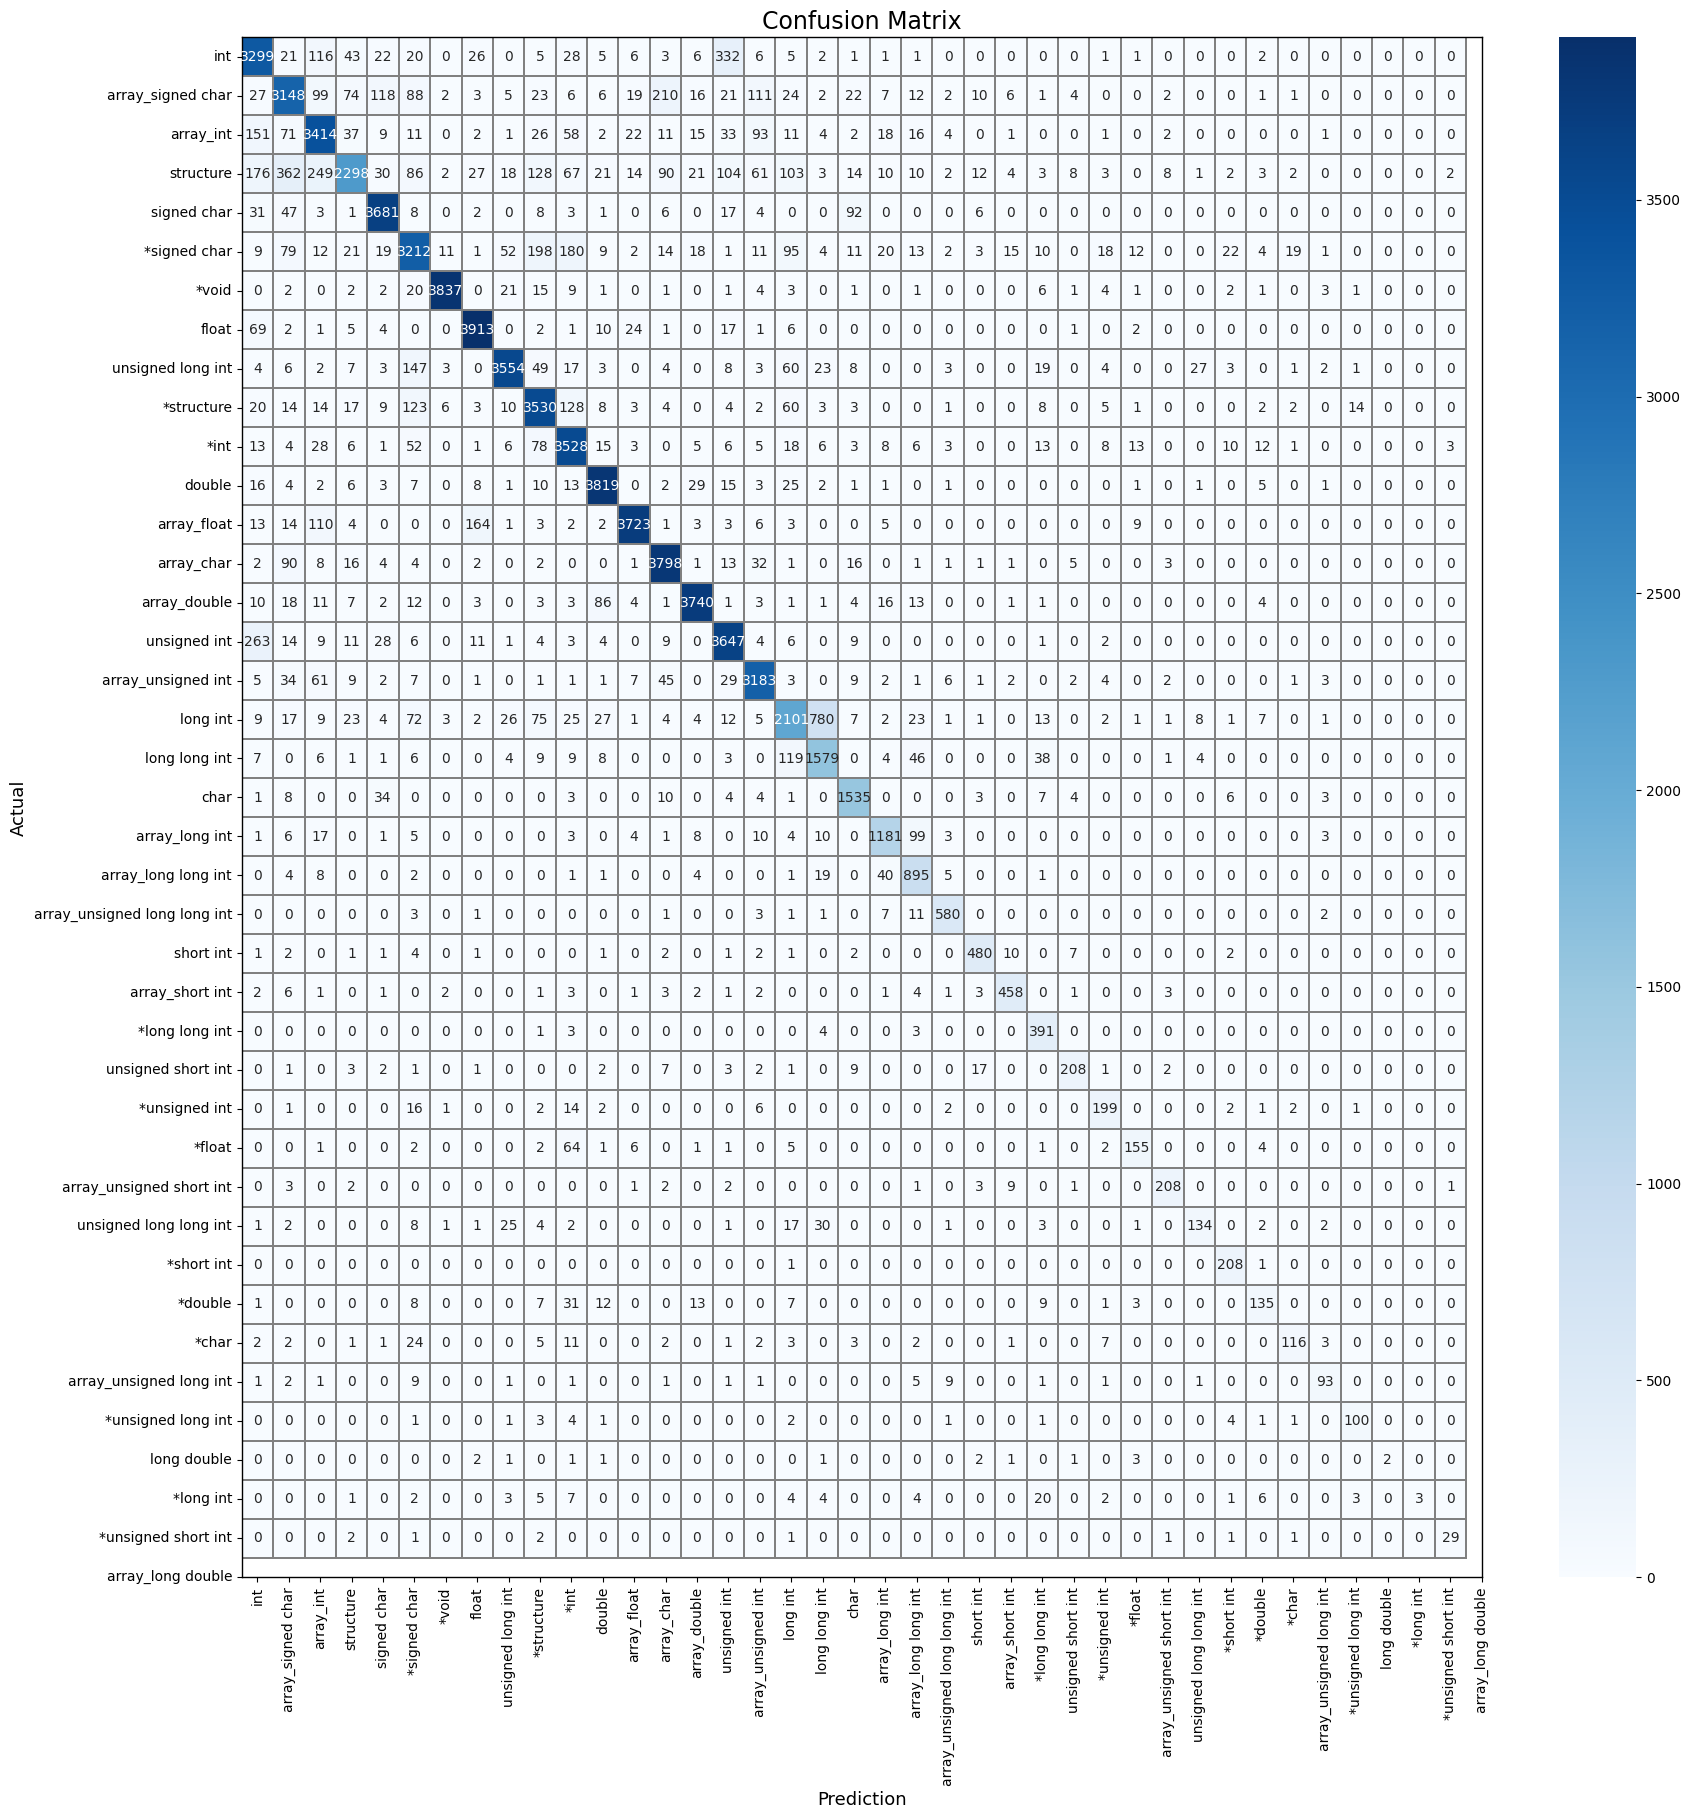

[0.81597823 0.78172337 0.83288607 0.70253745 0.93284339 0.79652821
 0.98296401 0.95044936 0.92407696 0.86150092 0.87283523 0.9517757
 0.94169723 0.92240437 0.95517814 0.87731537 0.91059934 0.70503356
 0.73051122 0.90962963 0.88167227 0.83333333 0.93699515 0.90566038
 0.91144279 0.82402529 0.82703777 0.77431907 0.69196429 0.89270386
 0.65206813 0.87763713 0.64593301 0.6966967  0.75609756 0.83333333
 0.23529412 0.08823529 0.79452055] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int', 

Epoch 3: 100%|██| 10743/10743 [1:15:31<00:00,  2.37it/s, loss=0.13]


Training metrices:  {'accuracy': 0.8900608204555328, 'precision': 0.890369951587693, 'recall': 0.8900608204555328, 'f1': 0.8897044956056667, 'loss': 0.3590092768579142}


Epoch 3: 100%|██████| 2686/2686 [08:24<00:00,  5.32it/s, loss=0.31]


CONFUSION PER CLASS [0.85218932 0.82182354 0.86208613 0.68577225 0.95653286 0.84748658
 0.97639594 0.96330049 0.93989899 0.90285428 0.92710765 0.97331991
 0.95794393 0.94326418 0.95842839 0.91714215 0.94218978 0.66574839
 0.9143167  0.94273399 0.93294031 0.87461774 0.97377049 0.92678227
 0.9516129  0.94527363 0.90384615 0.83534137 0.71428571 0.93991416
 0.6893617  0.9952381  0.64317181 0.74193548 0.7578125  0.85
 0.53333333 0.33846154 0.76315789] 0.8528562195840396


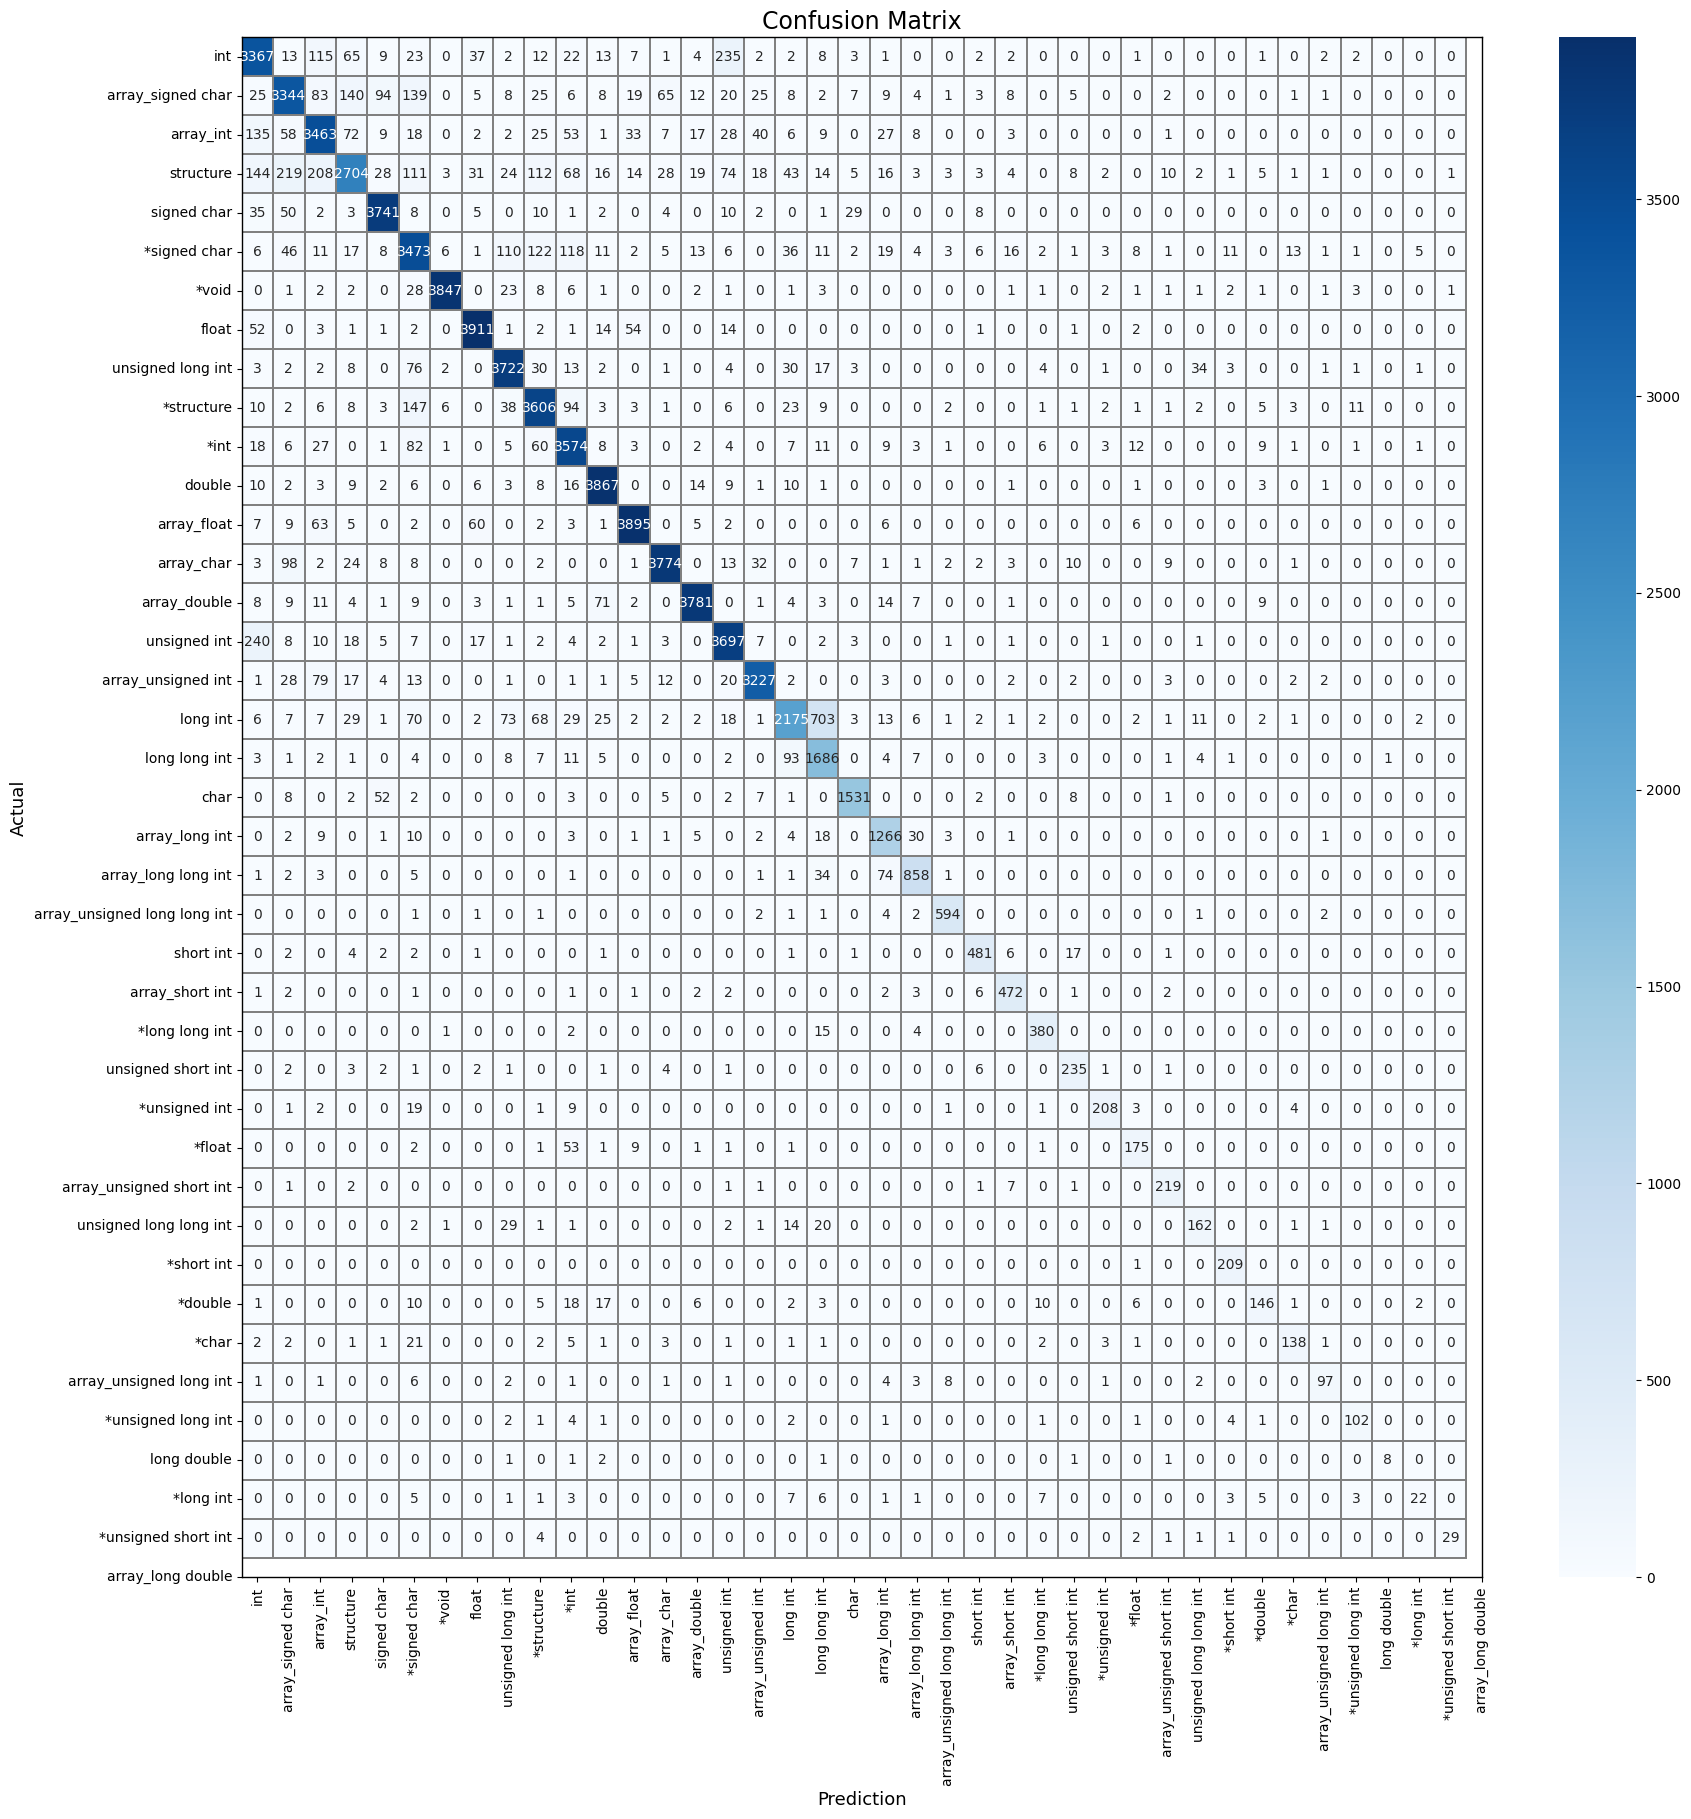

[0.83860523 0.83662747 0.85180175 0.76362609 0.94901065 0.82582333
 0.98552581 0.96046169 0.92841108 0.88894367 0.89517846 0.9609841
 0.95959596 0.95327103 0.96577267 0.90115783 0.94981604 0.75757576
 0.76237848 0.95152268 0.89438361 0.89142857 0.96506905 0.92322457
 0.92097561 0.92345079 0.85299456 0.87394958 0.74786325 0.89570552
 0.71052632 0.93932584 0.70531401 0.78186969 0.80833333 0.83606557
 0.66666667 0.44897959 0.84057971] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int', 

Epoch 4: 100%|█| 10743/10743 [1:15:30<00:00,  2.37it/s, loss=0.136]


Training metrices:  {'accuracy': 0.914510022962825, 'precision': 0.9145486141332339, 'recall': 0.914510022962825, 'f1': 0.9143001208270277, 'loss': 0.27761319680567714}


Epoch 4: 100%|█████| 2686/2686 [08:24<00:00,  5.33it/s, loss=0.232]


CONFUSION PER CLASS [0.86234818 0.83878103 0.86980334 0.77377631 0.95933504 0.81625183
 0.97994924 0.97363883 0.93331649 0.9338843  0.91180285 0.97157233
 0.94393902 0.95902049 0.973891   0.90250558 0.95502336 0.776485
 0.86612466 0.95874384 0.93588799 0.9235474  0.97213115 0.9460501
 0.9233871  0.97761194 0.89230769 0.87148594 0.7755102  0.93562232
 0.76595745 0.99047619 0.74889868 0.77956989 0.8359375  0.875
 0.66666667 0.49230769 0.76315789] 0.8777360643273671


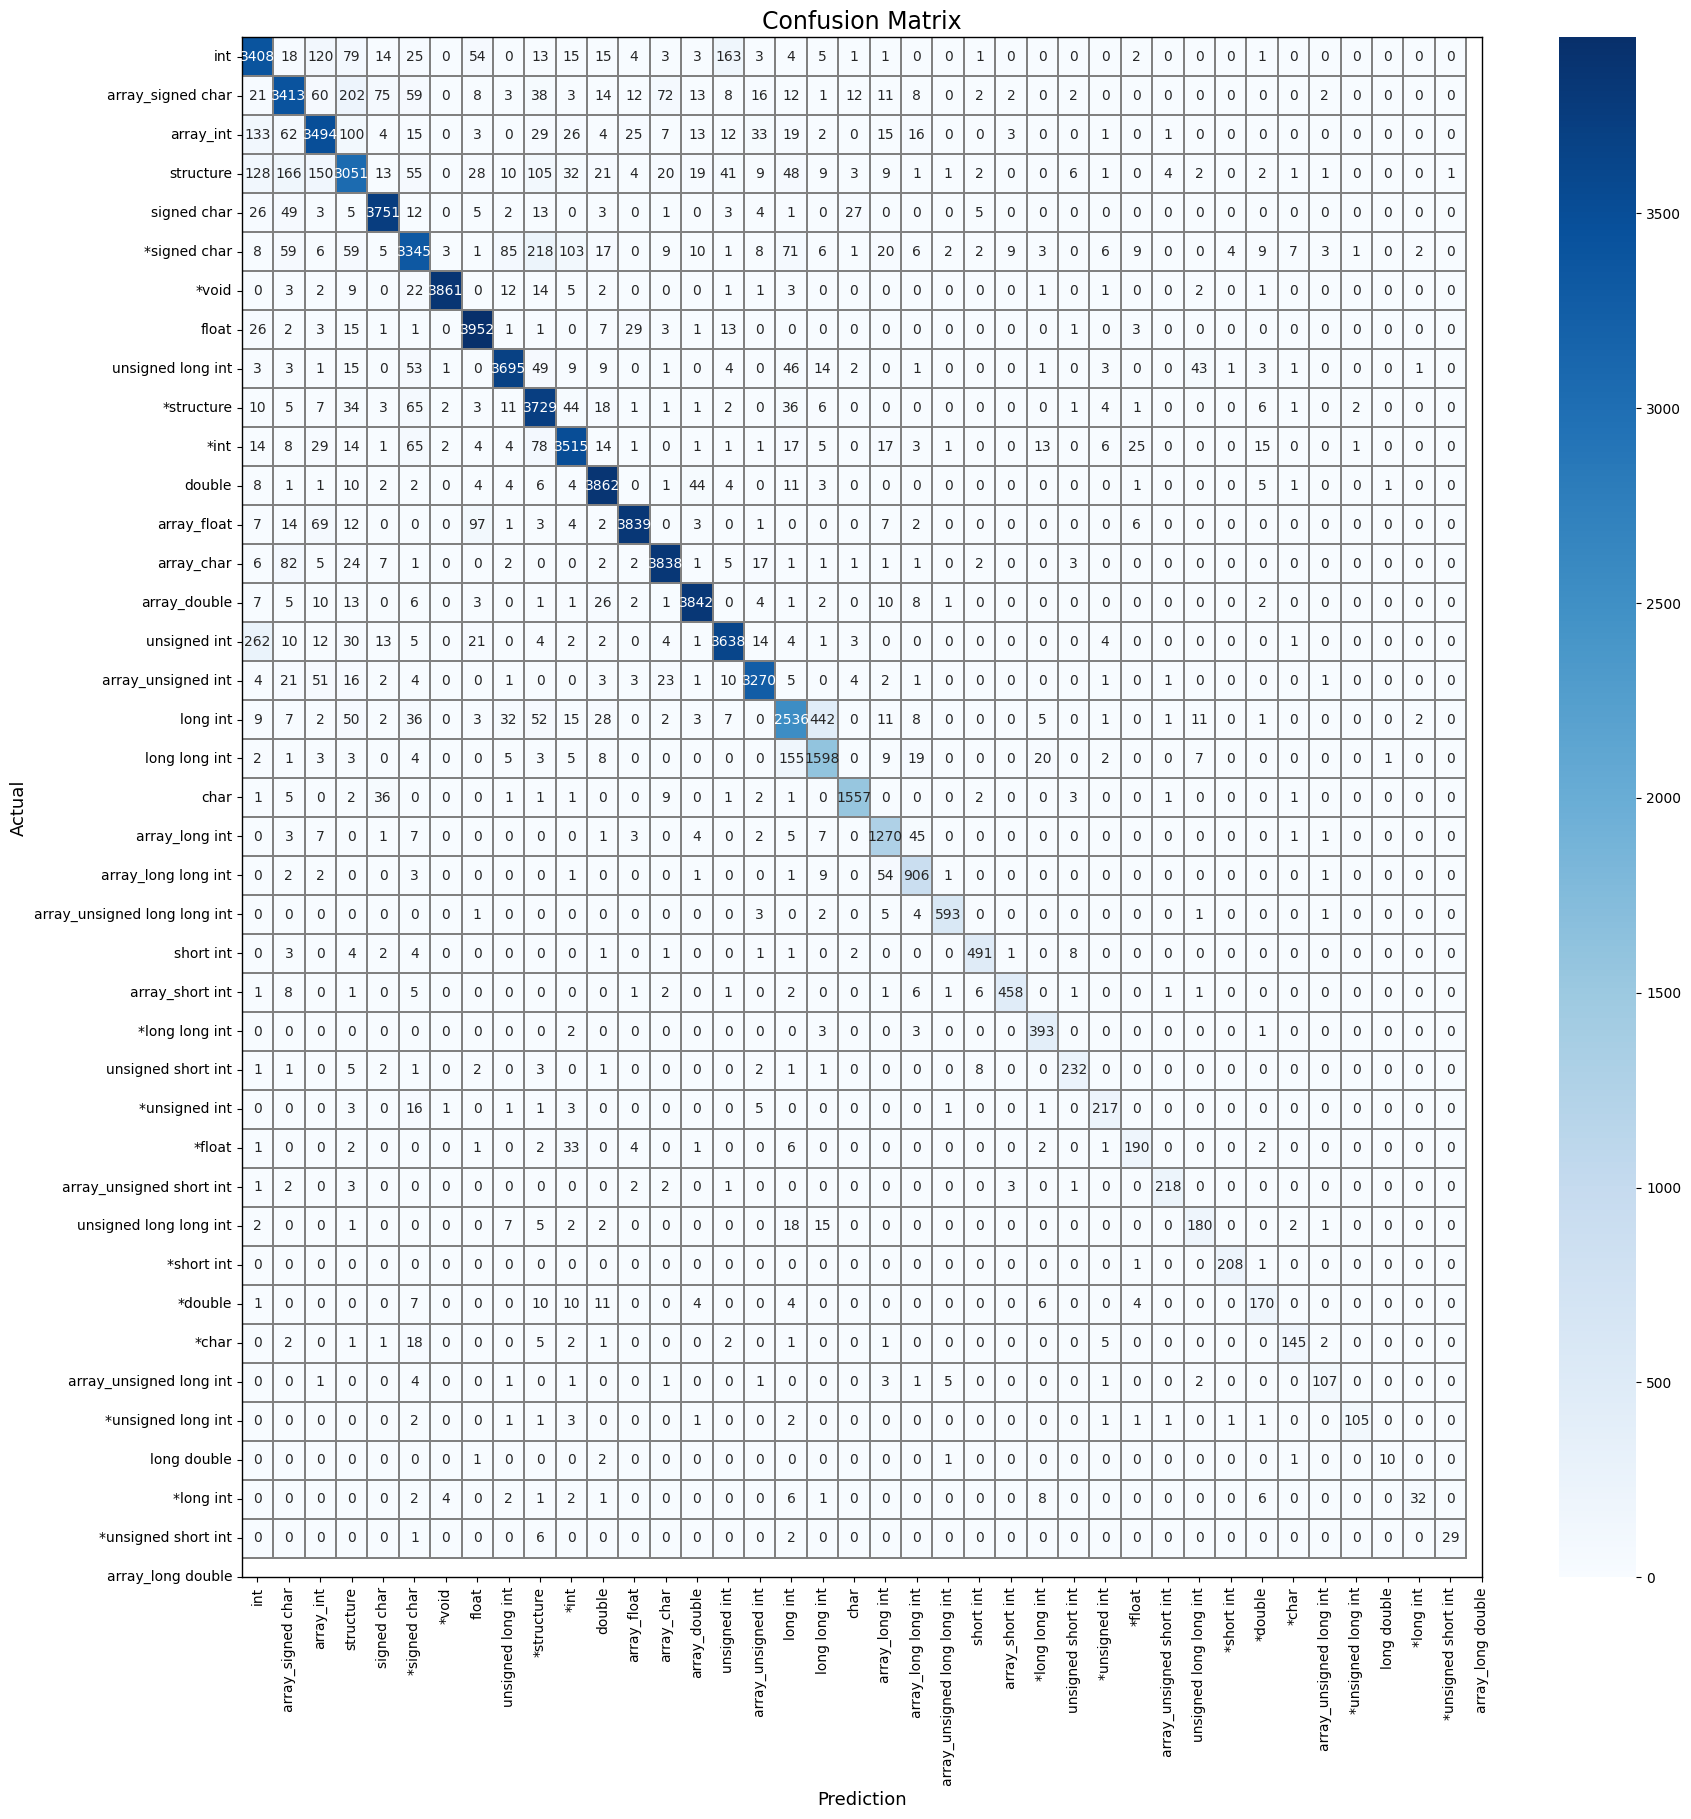

[0.84755036 0.85069791 0.86753569 0.79185051 0.95627788 0.84225104
 0.98822626 0.95806061 0.94260204 0.88955153 0.91322421 0.95926478
 0.95986998 0.95914032 0.97118301 0.91533526 0.95880369 0.80687241
 0.8034188  0.96200185 0.90584879 0.8970297  0.97452753 0.94423077
 0.94238683 0.91929825 0.8957529  0.86111111 0.77868852 0.94577007
 0.74380165 0.98113208 0.75055188 0.83333333 0.86290323 0.91703057
 0.74074074 0.62745098 0.85294118] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 5: 100%|█| 10743/10743 [1:15:33<00:00,  2.37it/s, loss=0.306]


Training metrices:  {'accuracy': 0.9318748836343326, 'precision': 0.9318703899830539, 'recall': 0.9318748836343326, 'f1': 0.9317564312025458, 'loss': 0.21896163914776615}


Epoch 5: 100%|█████| 2686/2686 [08:25<00:00,  5.32it/s, loss=0.087]


CONFUSION PER CLASS [0.83881579 0.84324324 0.8802589  0.70786802 0.96803069 0.86505612
 0.98070576 0.96503324 0.94370109 0.9391435  0.93931535 0.97559134
 0.96163305 0.97176412 0.97084918 0.93526786 0.96963504 0.80869299
 0.88943089 0.95748614 0.95427729 0.92762487 0.98032787 0.94797688
 0.9516129  0.9800995  0.90384615 0.87550201 0.76326531 0.96566524
 0.9017094  1.         0.79735683 0.82795699 0.8671875  0.88333333
 0.6        0.55384615 0.84210526] 0.8932106617085456


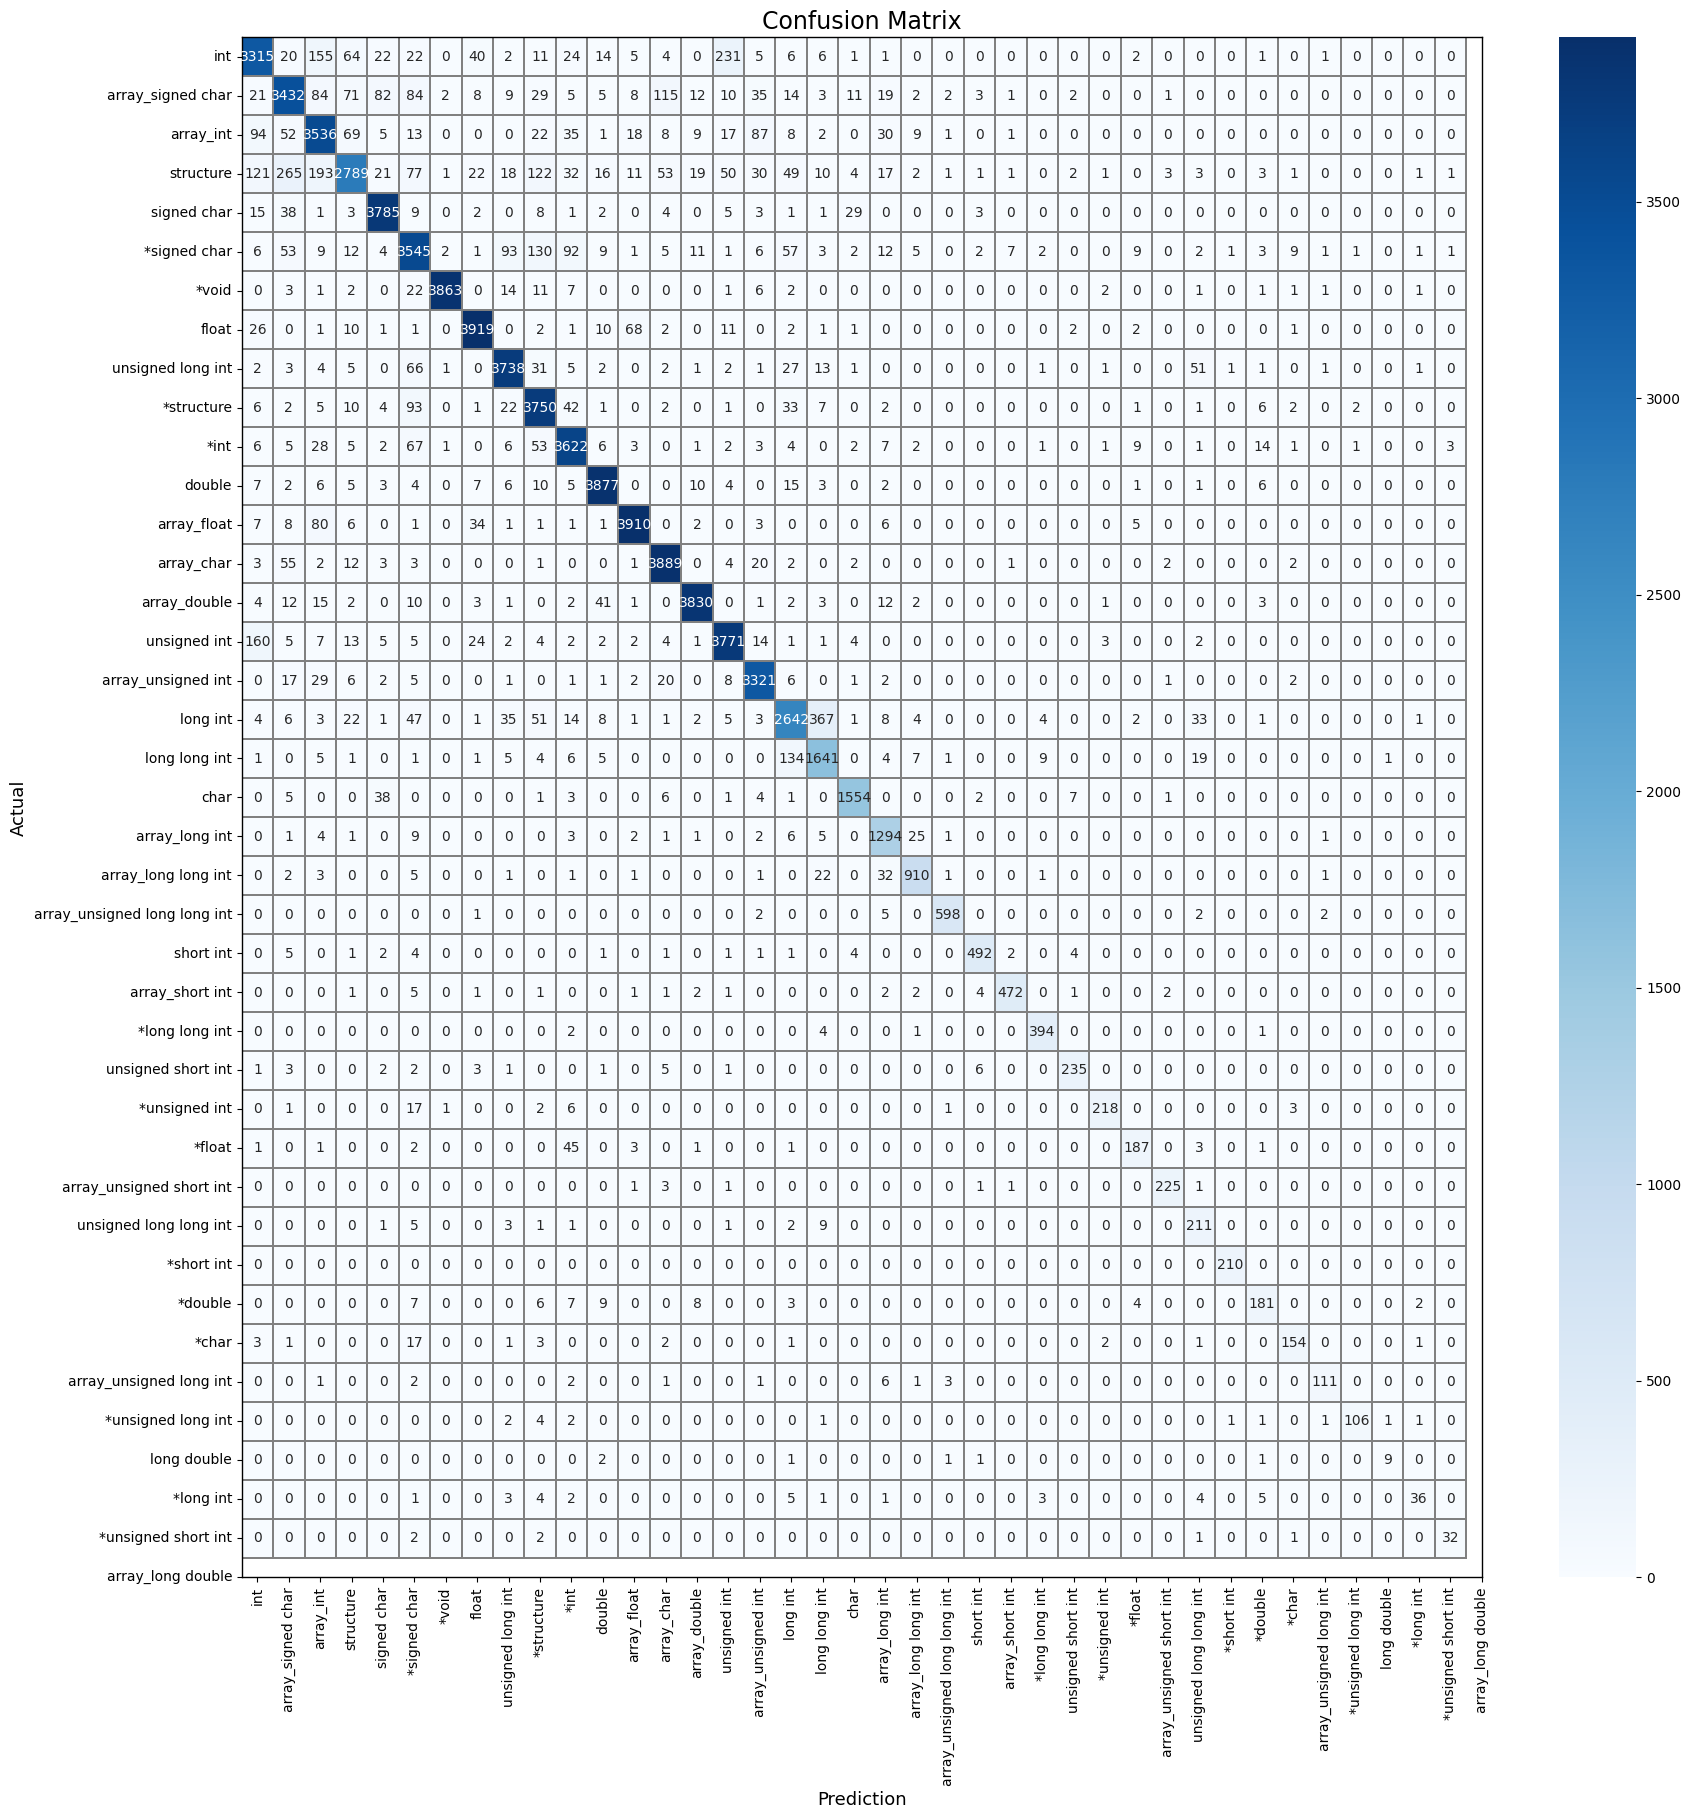

[0.8549323  0.85097942 0.86349206 0.79120567 0.95907766 0.85928978
 0.98924456 0.96420224 0.94334385 0.90832021 0.92551425 0.97070606
 0.96483652 0.95658591 0.97517505 0.92415145 0.95239461 0.83966312
 0.83130699 0.95925926 0.91838183 0.93189964 0.98032787 0.9516441
 0.96130346 0.96450428 0.91617934 0.91213389 0.80085653 0.96153846
 0.73905429 0.9929078  0.79385965 0.84848485 0.89516129 0.92173913
 0.69230769 0.65454545 0.85333333] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int', 

Epoch 6: 100%|█| 10743/10743 [1:15:31<00:00,  2.37it/s, loss=0.308]


Training metrices:  {'accuracy': 0.9460218457146403, 'precision': 0.9460042754835958, 'recall': 0.9460218457146403, 'f1': 0.9459528145870428, 'loss': 0.17294449149726332}


Epoch 6: 100%|█████| 2686/2686 [08:24<00:00,  5.32it/s, loss=0.604]


CONFUSION PER CLASS [0.8364557  0.83316953 0.8334578  0.77808775 0.97237852 0.87628111
 0.98147208 0.94876847 0.95479798 0.90660991 0.93694862 0.97433962
 0.96852717 0.96851574 0.97946247 0.95833333 0.97138686 0.88334354
 0.85474255 0.966133   0.95280236 0.96228338 0.99016393 0.97302505
 0.94758065 0.96517413 0.91538462 0.93574297 0.79591837 0.94420601
 0.80851064 1.         0.74889868 0.89784946 0.8828125  0.8907563
 0.73333333 0.75384615 0.84210526] 0.9057334763938161


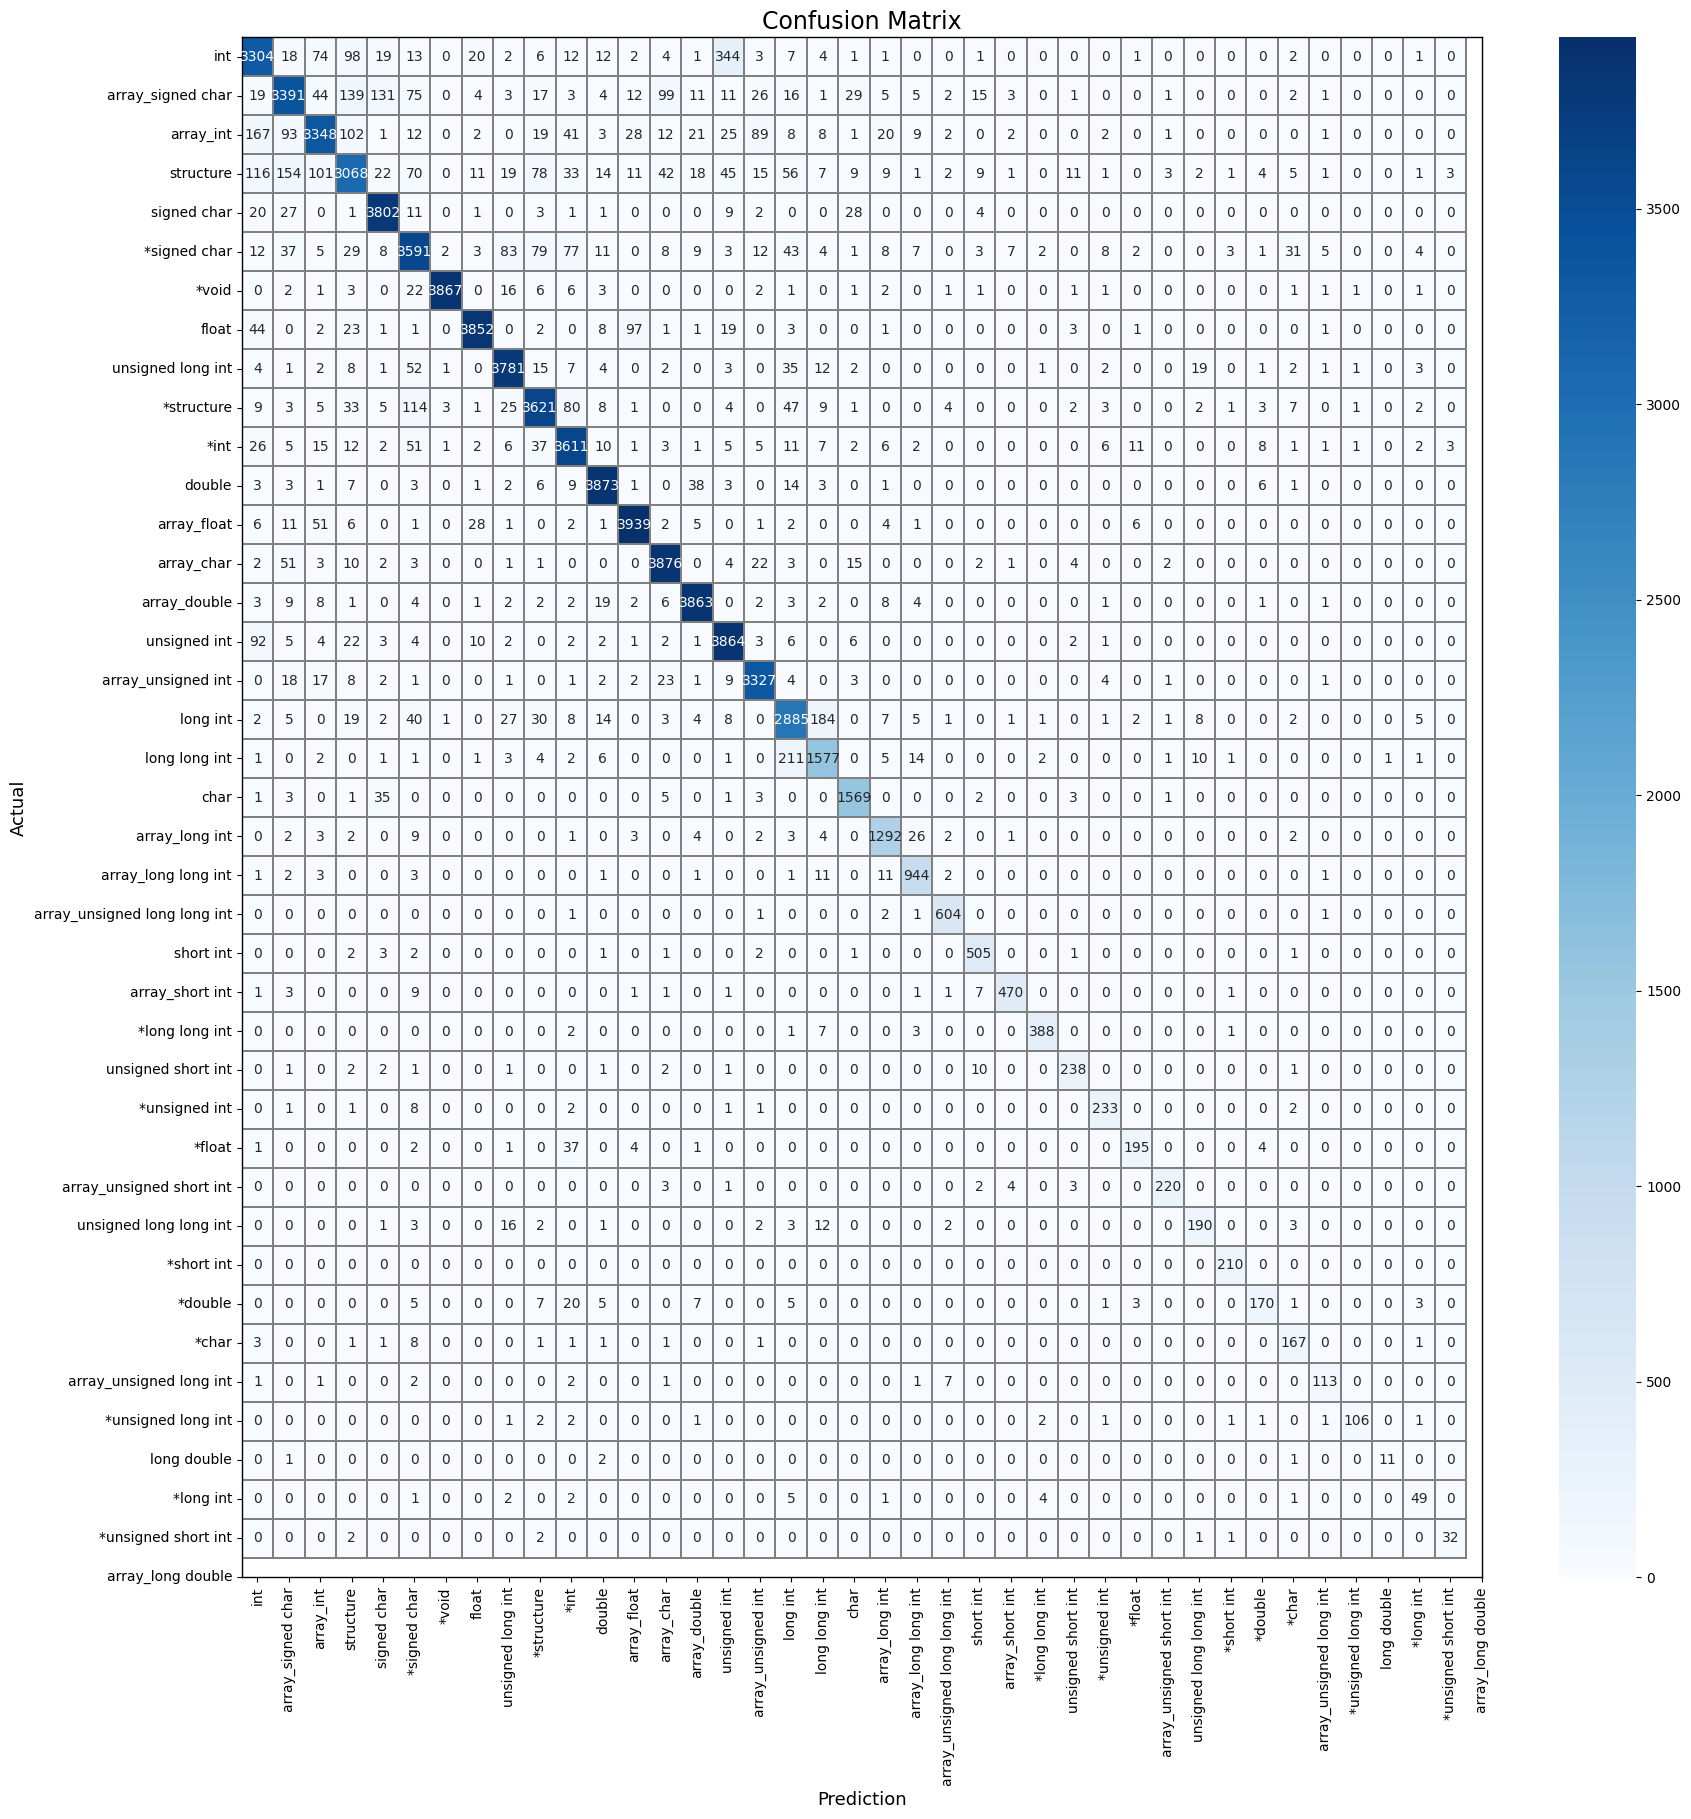

[0.84848485 0.85674583 0.86882055 0.81346944 0.95599698 0.87372263
 0.98963532 0.96336126 0.95059711 0.91278044 0.92341133 0.97043348
 0.96402349 0.9571552  0.97402925 0.92065761 0.95796142 0.86910679
 0.85312415 0.95293046 0.94341    0.94164589 0.97419355 0.93518519
 0.95334686 0.96758105 0.89981096 0.90661479 0.83690987 0.94827586
 0.8137045  0.97674419 0.79812207 0.79713604 0.87596899 0.92576419
 0.81481481 0.70503597 0.84210526] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 7: 100%|█| 10743/10743 [1:15:30<00:00,  2.37it/s, loss=0.0412


Training metrices:  {'accuracy': 0.9567585179668591, 'precision': 0.9567383793832633, 'recall': 0.9567585179668591, 'f1': 0.9567108103134899, 'loss': 0.1373354502469981}


Epoch 7: 100%|█████| 2686/2686 [08:25<00:00,  5.32it/s, loss=0.364]


CONFUSION PER CLASS [0.86567164 0.78569673 0.8877551  0.76433283 0.96214834 0.85334309
 0.98375635 0.97068966 0.95051755 0.93937876 0.94345006 0.96981891
 0.97787067 0.97575606 0.98427992 0.94145373 0.97488318 0.90205081
 0.81832972 0.96982759 0.95648968 0.97349643 0.98852459 0.96531792
 0.96572581 0.97263682 0.93076923 0.92771084 0.8122449  0.96137339
 0.79487179 0.9952381  0.78414097 0.88709677 0.875      0.90833333
 0.73333333 0.73846154 0.76315789] 0.90653676982712


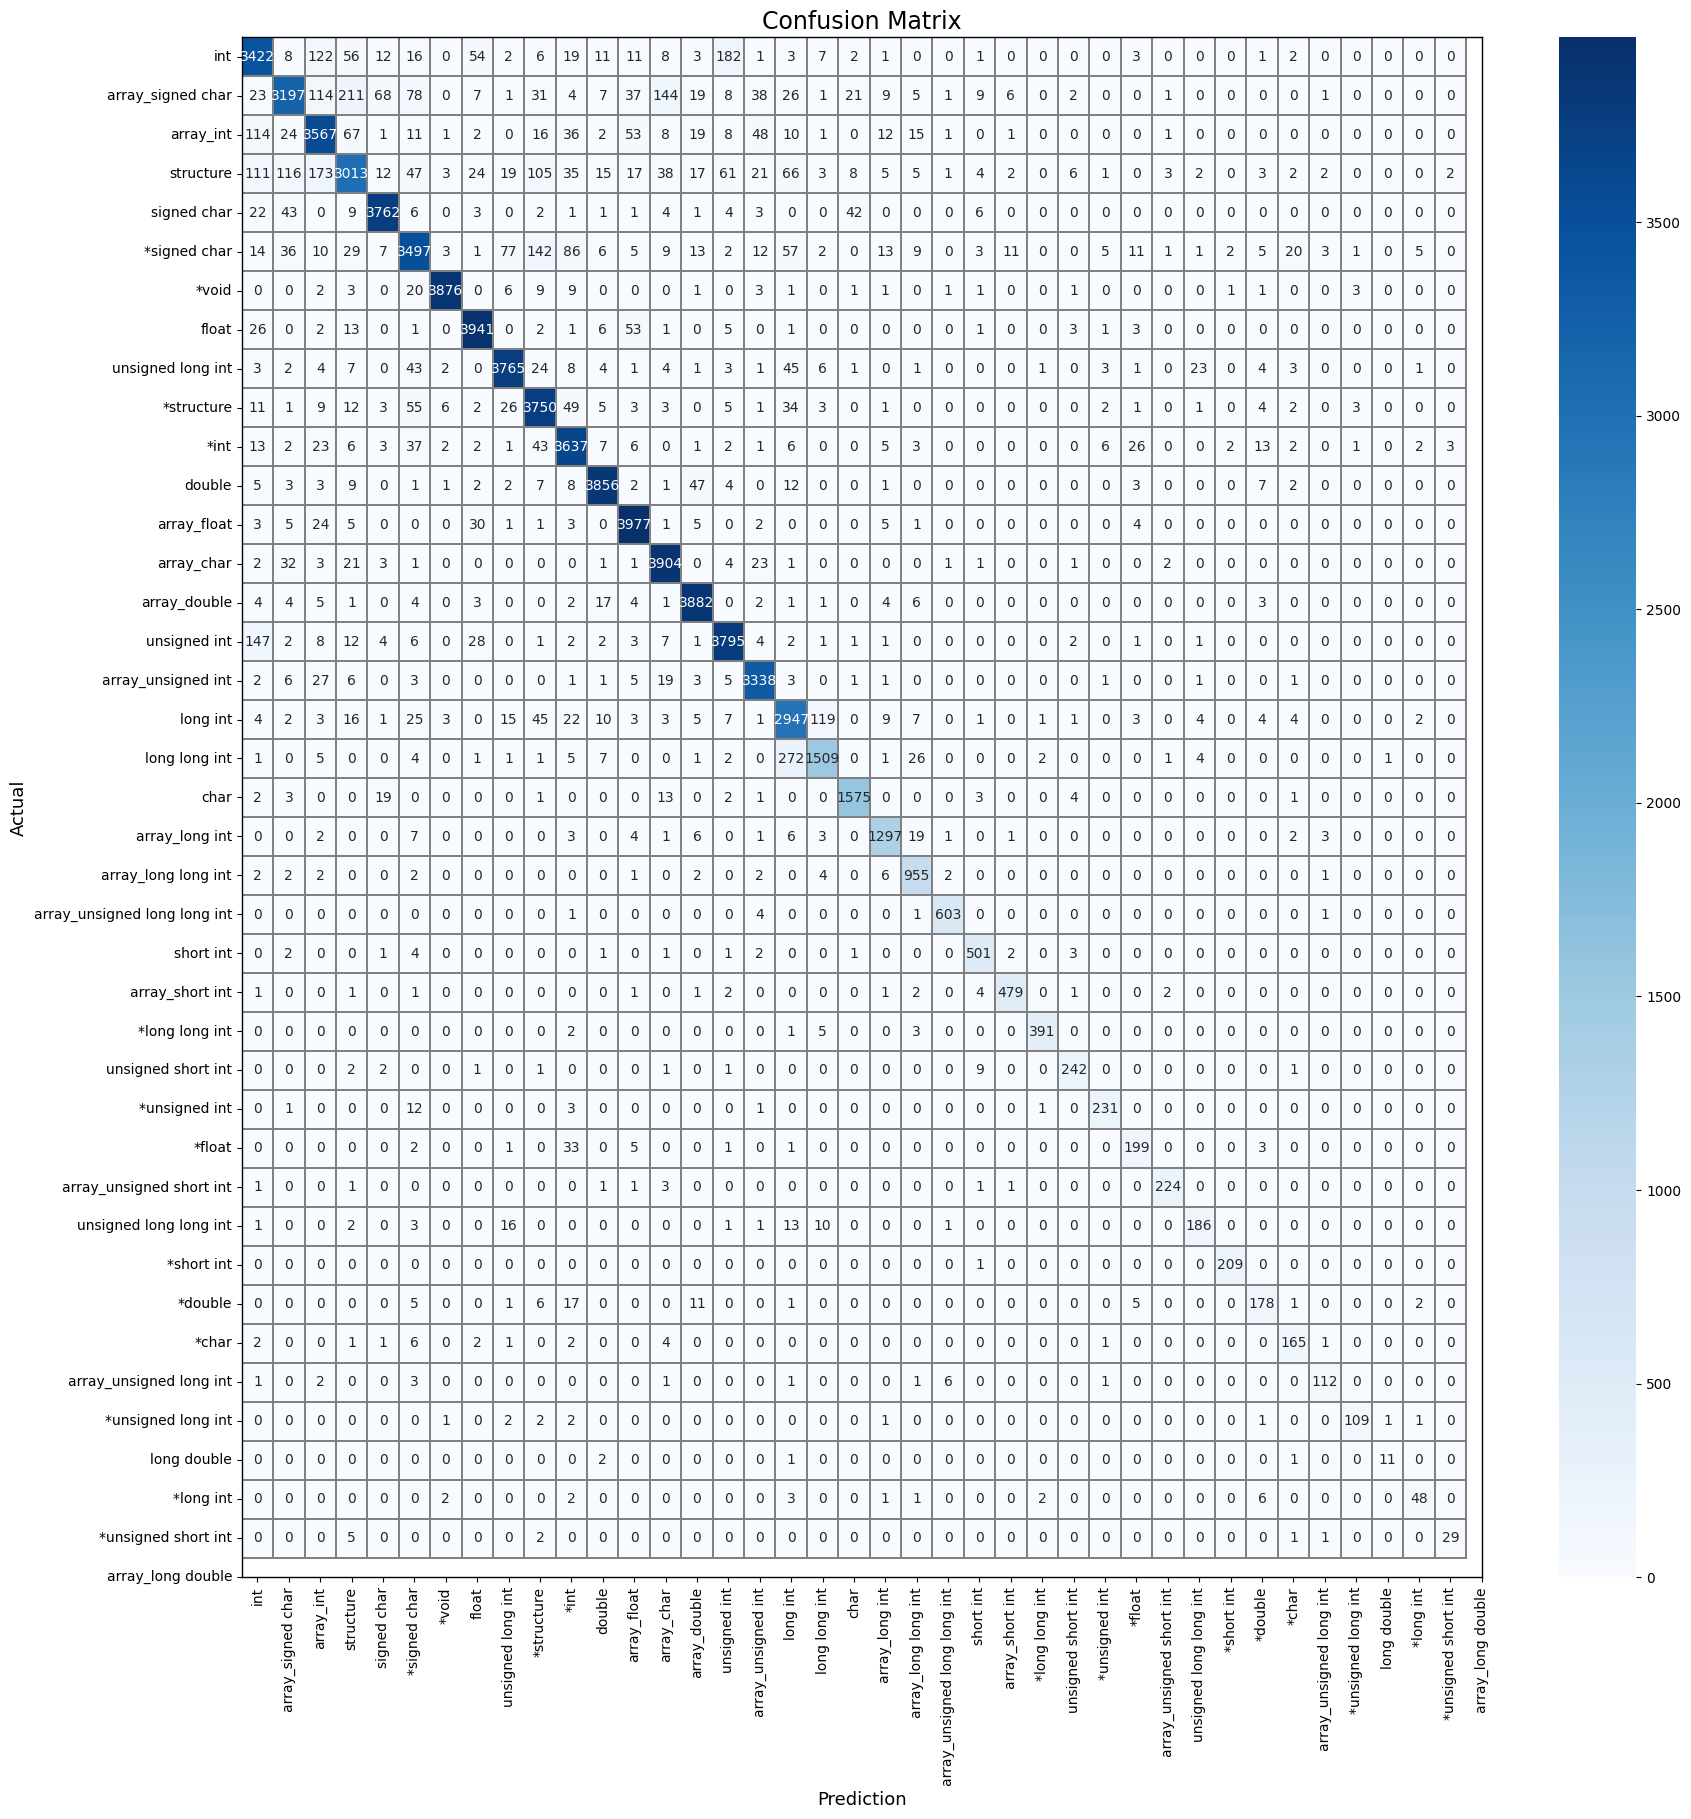

[0.86742712 0.8457672  0.87770669 0.80885906 0.96350365 0.87446862
 0.98877551 0.96557638 0.95340593 0.91586274 0.92686035 0.97152935
 0.96283743 0.95452323 0.9725667  0.93289086 0.96265321 0.86919333
 0.85763001 0.96124504 0.94983523 0.93581578 0.98208469 0.94084507
 0.95895896 0.9775     0.92015209 0.92215569 0.78811881 0.95726496
 0.81400438 0.98584906 0.77391304 0.83333333 0.88537549 0.91983122
 0.78571429 0.76190476 0.80555556] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 8: 100%|█| 10743/10743 [1:15:31<00:00,  2.37it/s, loss=0.0177


Training metrices:  {'accuracy': 0.964665177186123, 'precision': 0.9646391076364451, 'recall': 0.964665177186123, 'f1': 0.9646288052999846, 'loss': 0.11145158663038637}


Epoch 8: 100%|█████| 2686/2686 [08:24<00:00,  5.32it/s, loss=0.141]


CONFUSION PER CLASS [0.87958513 0.82407862 0.89666335 0.77358012 0.97570332 0.82519531
 0.98807107 0.96205962 0.95705986 0.91182365 0.93879668 0.97157233
 0.96606836 0.97251374 0.98326148 0.96254031 0.96788321 0.86531987
 0.93170732 0.96428571 0.96389094 0.96534149 0.99016393 0.96339114
 0.95766129 0.98756219 0.95       0.9437751  0.82040816 0.97854077
 0.89361702 1.         0.75770925 0.90322581 0.890625   0.925
 0.86666667 0.81538462 0.86842105] 0.9220295763995328


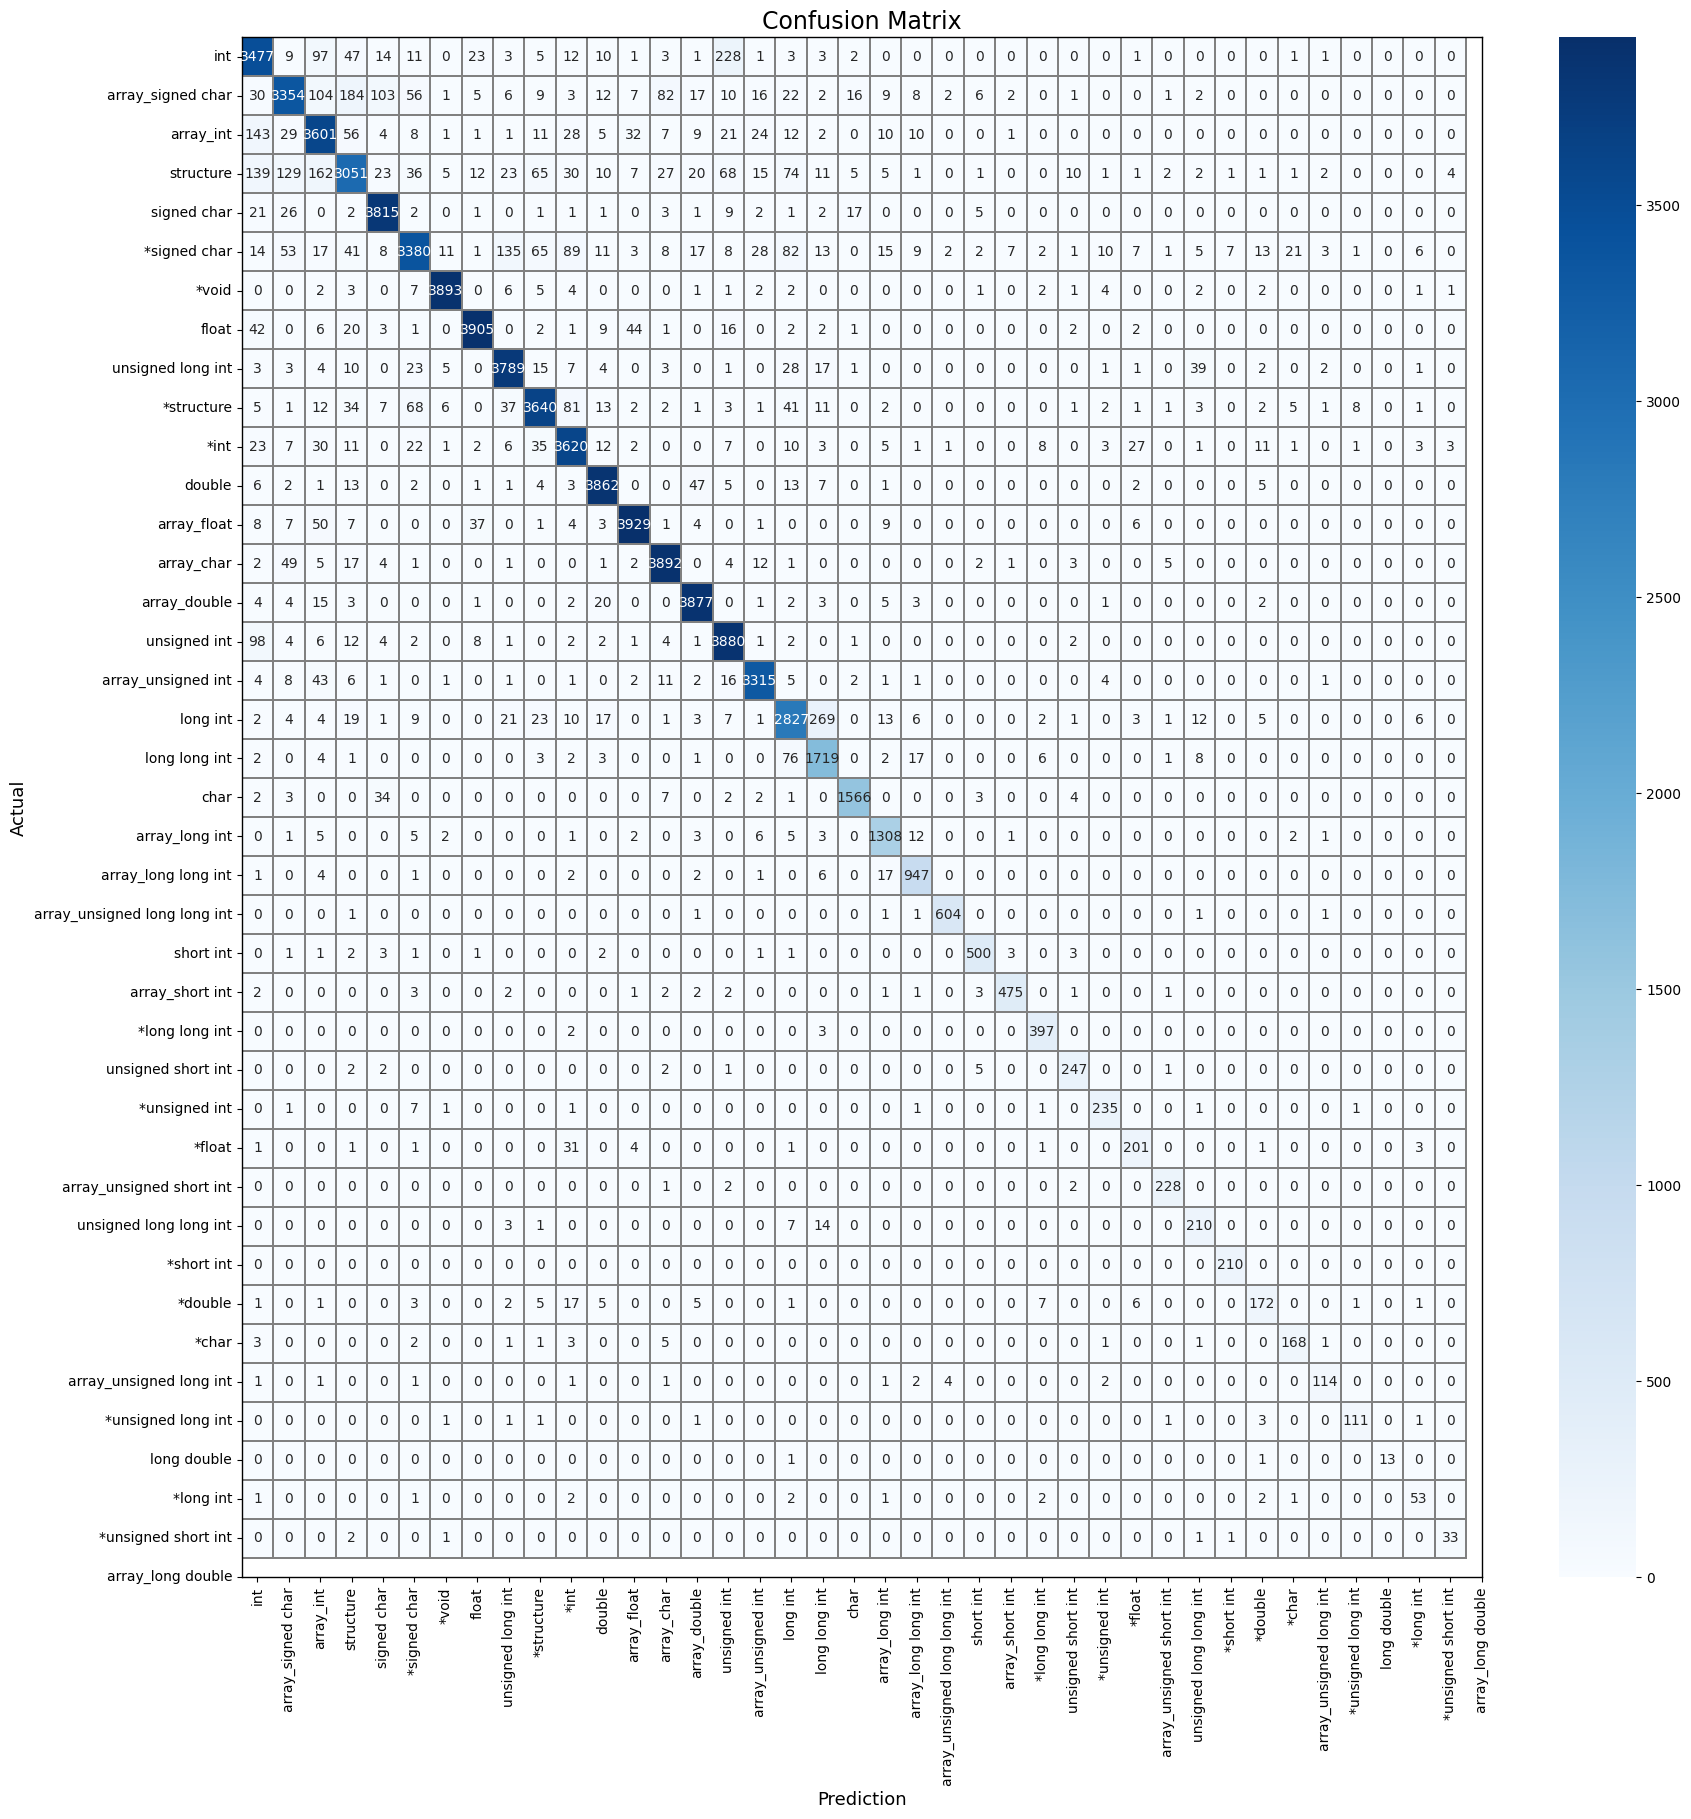

[0.87055583 0.86387637 0.87925772 0.81479503 0.96144153 0.87237063
 0.98945228 0.96934343 0.94736842 0.92338914 0.92630502 0.96828382
 0.96940538 0.96515809 0.974243   0.93246816 0.96717724 0.8713207
 0.87369759 0.96816074 0.94679696 0.94652674 0.98773508 0.95510984
 0.96348884 0.95662651 0.91651206 0.91617934 0.79920477 0.95798319
 0.80305927 0.97902098 0.76614699 0.87046632 0.89411765 0.91358025
 0.92857143 0.75177305 0.83544304] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int', 

Epoch 9: 100%|█| 10743/10743 [1:15:28<00:00,  2.37it/s, loss=0.0436


Training metrices:  {'accuracy': 0.970368646434556, 'precision': 0.9703492223592836, 'recall': 0.970368646434556, 'f1': 0.9703456460218537, 'loss': 0.09262311747042315}


Epoch 9: 100%|████| 2686/2686 [08:25<00:00,  5.31it/s, loss=0.0861]


CONFUSION PER CLASS [0.8697192  0.77985258 0.89472374 0.79006085 0.97800512 0.87207031
 0.98832487 0.9726601  0.96136364 0.95316804 0.92551259 0.96879718
 0.96703567 0.97301349 0.98681876 0.96452493 0.97313869 0.89072544
 0.89045553 0.96921182 0.96536478 0.95820591 0.99180328 0.97302505
 0.96774194 0.98258706 0.93076923 0.95180723 0.83673469 0.96137339
 0.85106383 1.         0.83700441 0.91397849 0.875      0.925
 0.73333333 0.70769231 0.86842105] 0.9179509881094537


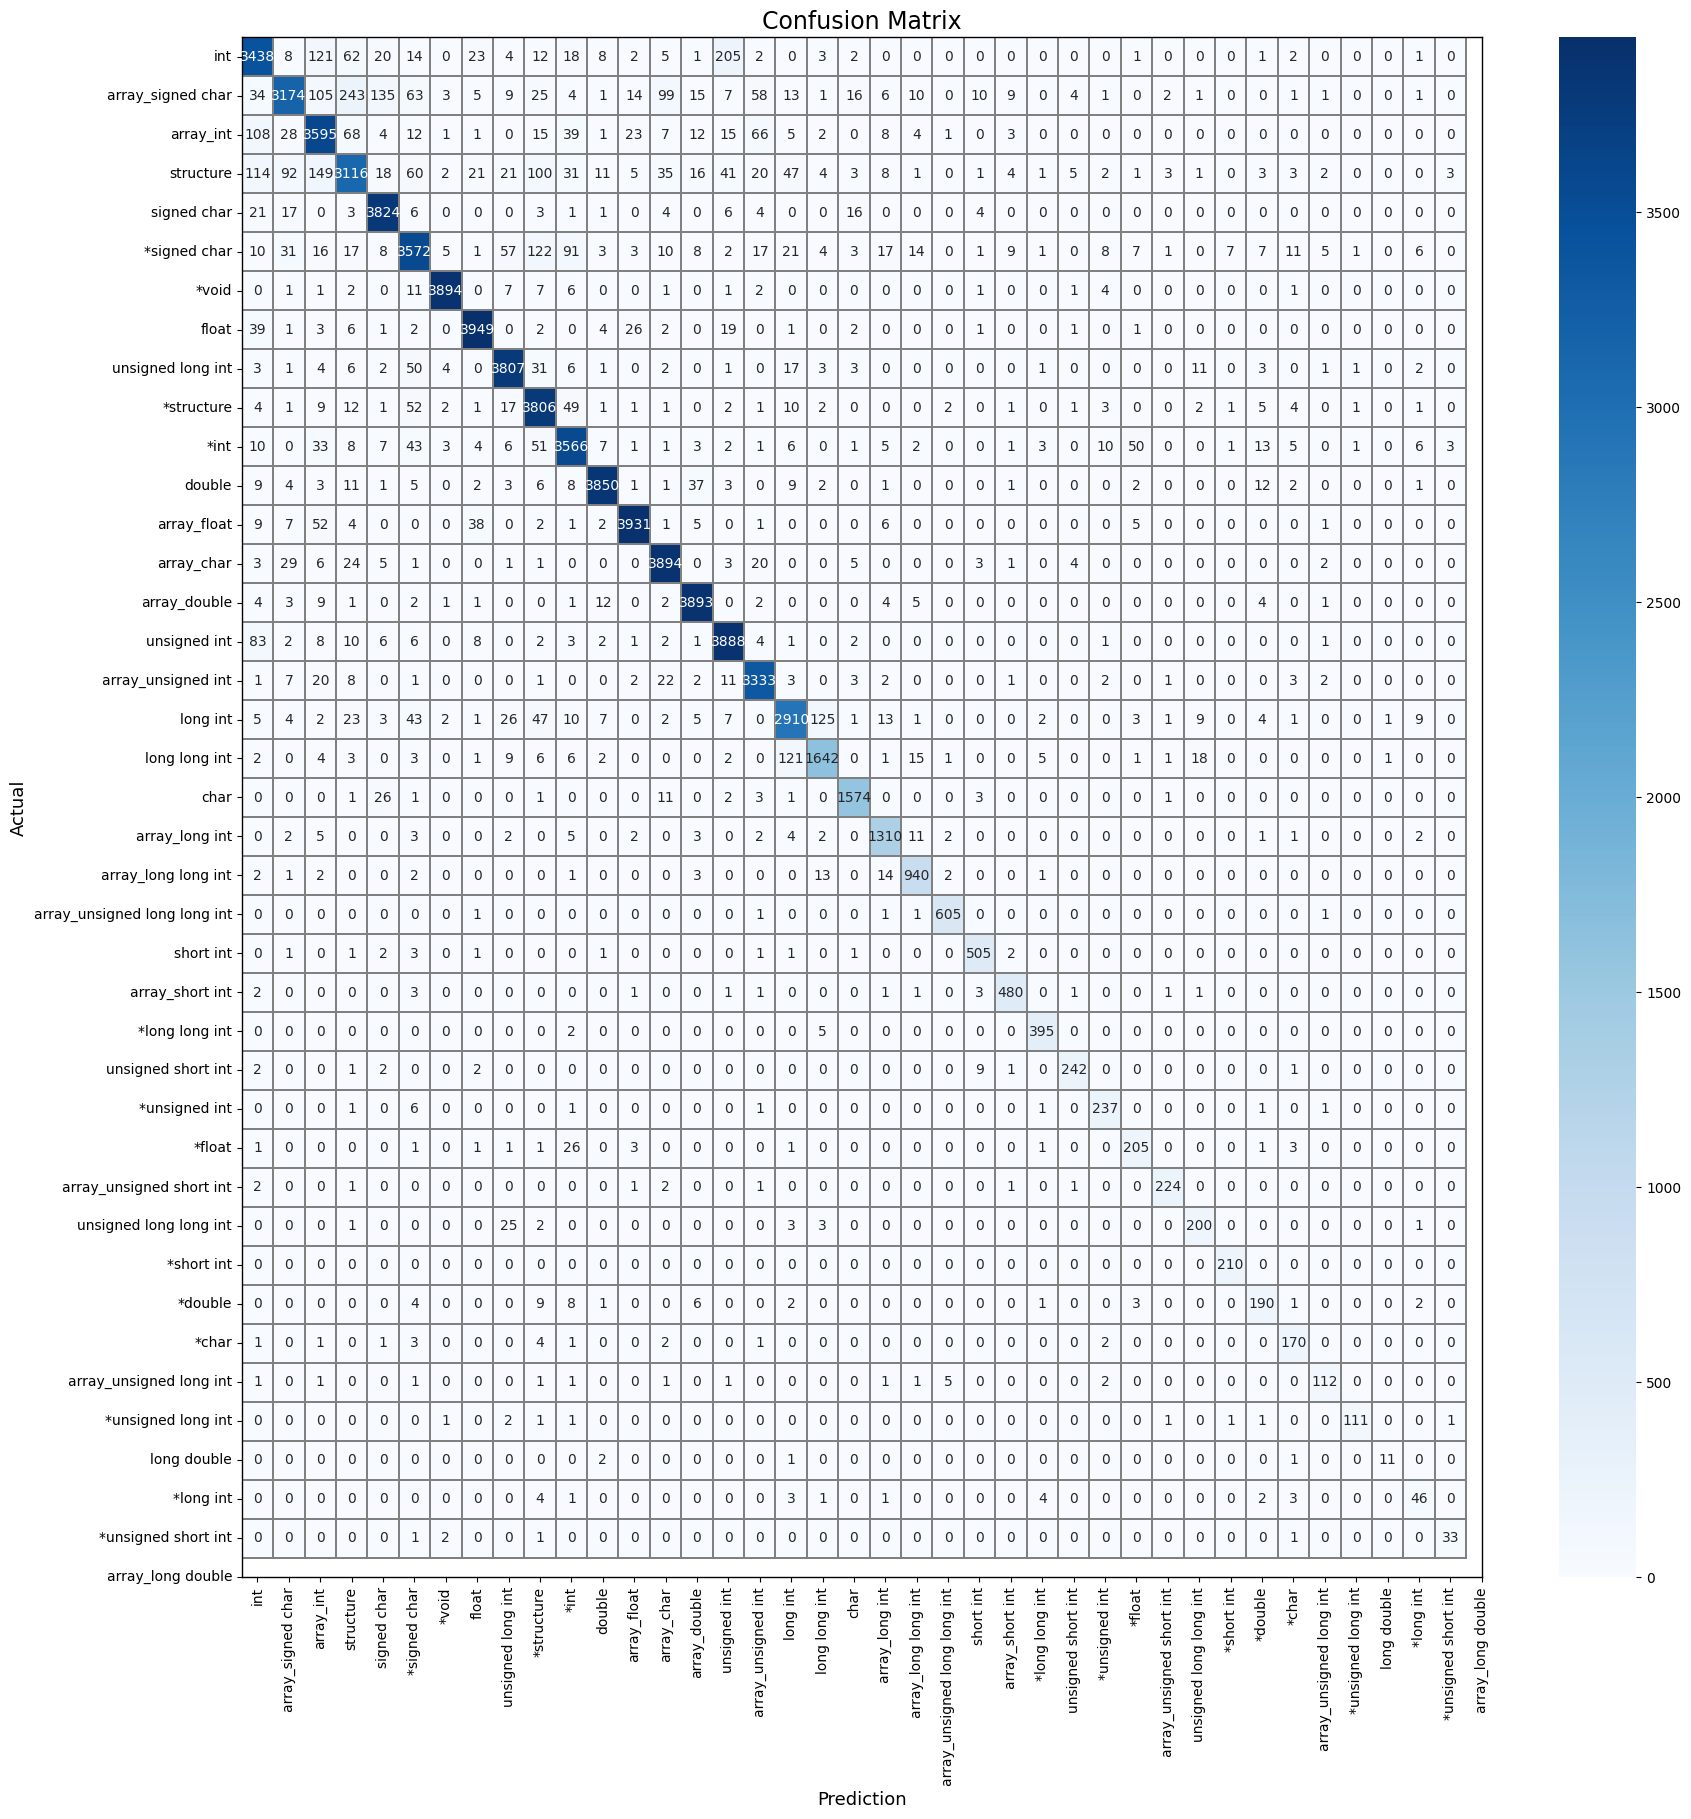

[0.87469788 0.84820951 0.88037223 0.82248911 0.95887663 0.88525403
 0.99083969 0.97254033 0.9568933  0.92199612 0.92144703 0.97579521
 0.97277902 0.96041435 0.9787555  0.94254545 0.95679633 0.90274546
 0.89824945 0.96683047 0.95065312 0.94614997 0.98534202 0.95283019
 0.95049505 0.96577017 0.93076923 0.90978887 0.78244275 0.95522388
 0.83682008 0.97674419 0.8        0.85       0.86821705 0.94468085
 0.78571429 0.64335664 0.84615385] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 10: 100%|█| 10743/10743 [1:15:30<00:00,  2.37it/s, loss=0.197


Training metrices:  {'accuracy': 0.9749550052752436, 'precision': 0.9749390818305063, 'recall': 0.9749550052752436, 'f1': 0.9749376962903624, 'loss': 0.0772004804461656}


Epoch 10: 100%|████| 2686/2686 [08:24<00:00,  5.33it/s, loss=0.142]


CONFUSION PER CLASS [0.85884139 0.84987715 0.89845694 0.75190259 0.96777494 0.9080039
 0.98603707 0.97044335 0.95581924 0.91687531 0.93955901 0.97408805
 0.97268701 0.97202098 0.97996957 0.9593254  0.97196262 0.89433384
 0.93058568 0.97104128 0.9624171  0.97655454 0.98688525 0.96339114
 0.96774194 0.9800995  0.93846154 0.92369478 0.82040816 0.97854077
 0.86808511 1.         0.78854626 0.88172043 0.875      0.90833333
 0.8        0.8        0.84210526] 0.9202971903003643


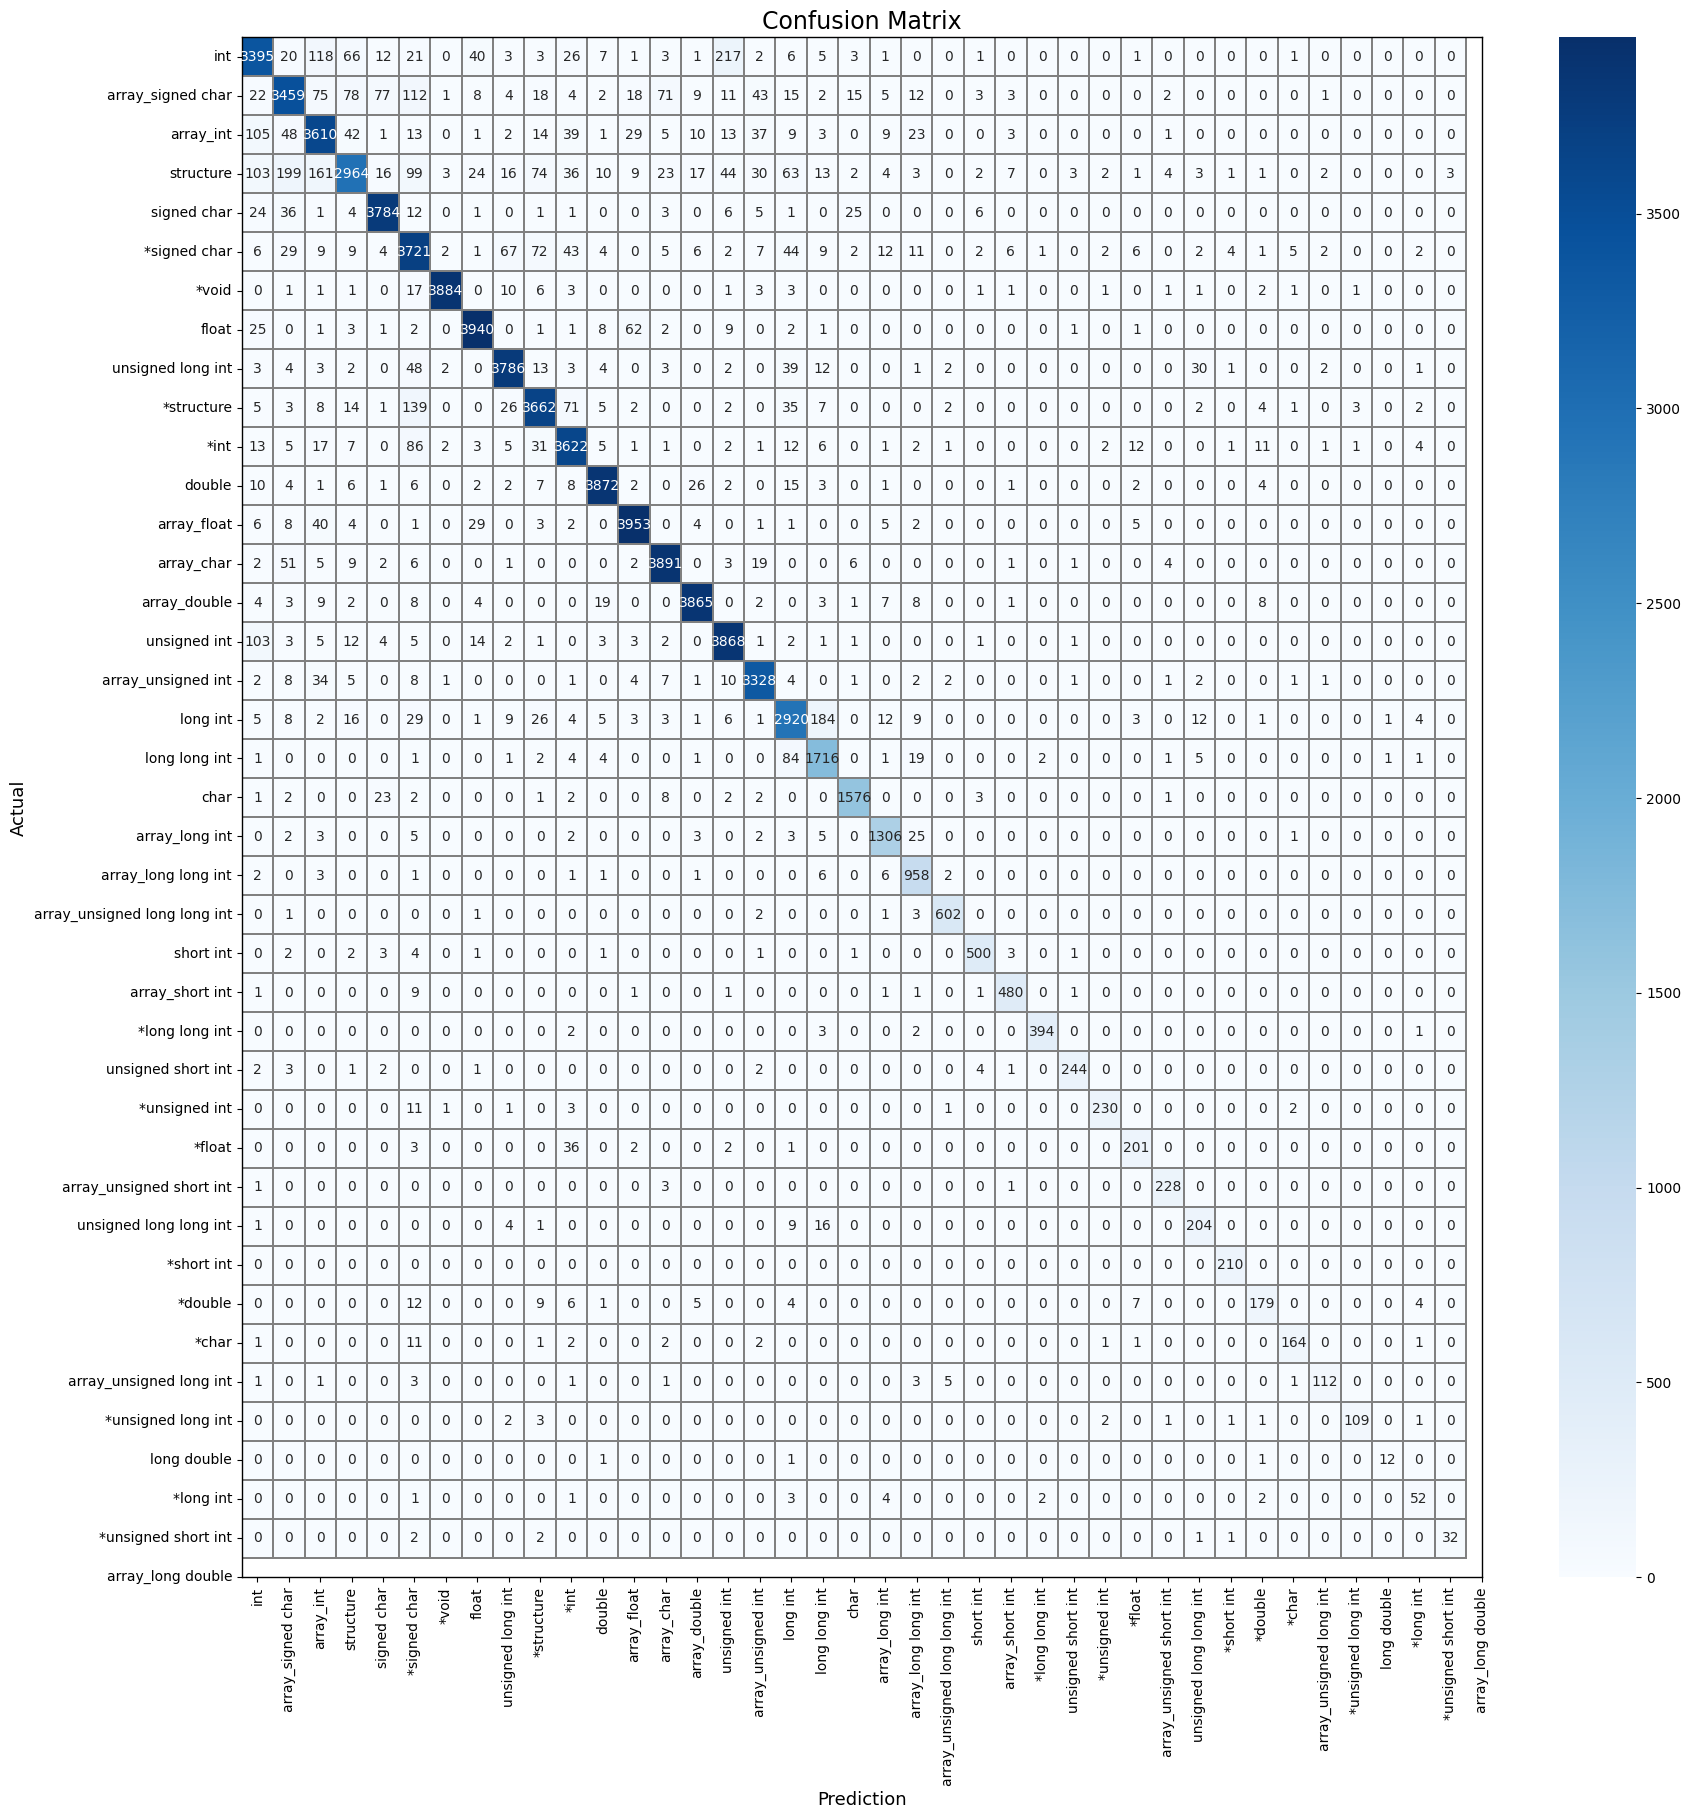

[0.87084776 0.86811394 0.88861538 0.82459313 0.96518301 0.87594162
 0.99144863 0.96913049 0.95823842 0.92183763 0.93122509 0.97679112
 0.96934772 0.96839223 0.97922473 0.93940498 0.96254519 0.89282984
 0.89398281 0.96805897 0.95572631 0.92784504 0.98125509 0.95877277
 0.9561753  0.98377029 0.95126706 0.9406953  0.82886598 0.95597484
 0.82092555 0.97902098 0.80995475 0.90358127 0.89959839 0.93162393
 0.82758621 0.75362319 0.87671233] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 11: 100%|█| 10743/10743 [1:15:31<00:00,  2.37it/s, loss=0.278


Training metrices:  {'accuracy': 0.9786631912120648, 'precision': 0.9786557140766032, 'recall': 0.9786631912120648, 'f1': 0.978654096733365, 'loss': 0.06599515728616269}


Epoch 11: 100%|████| 2686/2686 [08:24<00:00,  5.32it/s, loss=0.247]


CONFUSION PER CLASS [0.83350202 0.88009828 0.88673139 0.81633688 0.97340153 0.89970717
 0.98856998 0.95295567 0.95782828 0.90135203 0.92996109 0.98012579
 0.96434718 0.96726637 0.97996957 0.97048611 0.97721297 0.88980716
 0.92628726 0.95012315 0.95210022 0.96839959 0.9852459  0.95568401
 0.97782258 0.98258706 0.90384615 0.94779116 0.86530612 0.94849785
 0.91489362 1.         0.77973568 0.89784946 0.8984375  0.90833333
 0.8        0.75384615 0.86842105] 0.9214068556183924


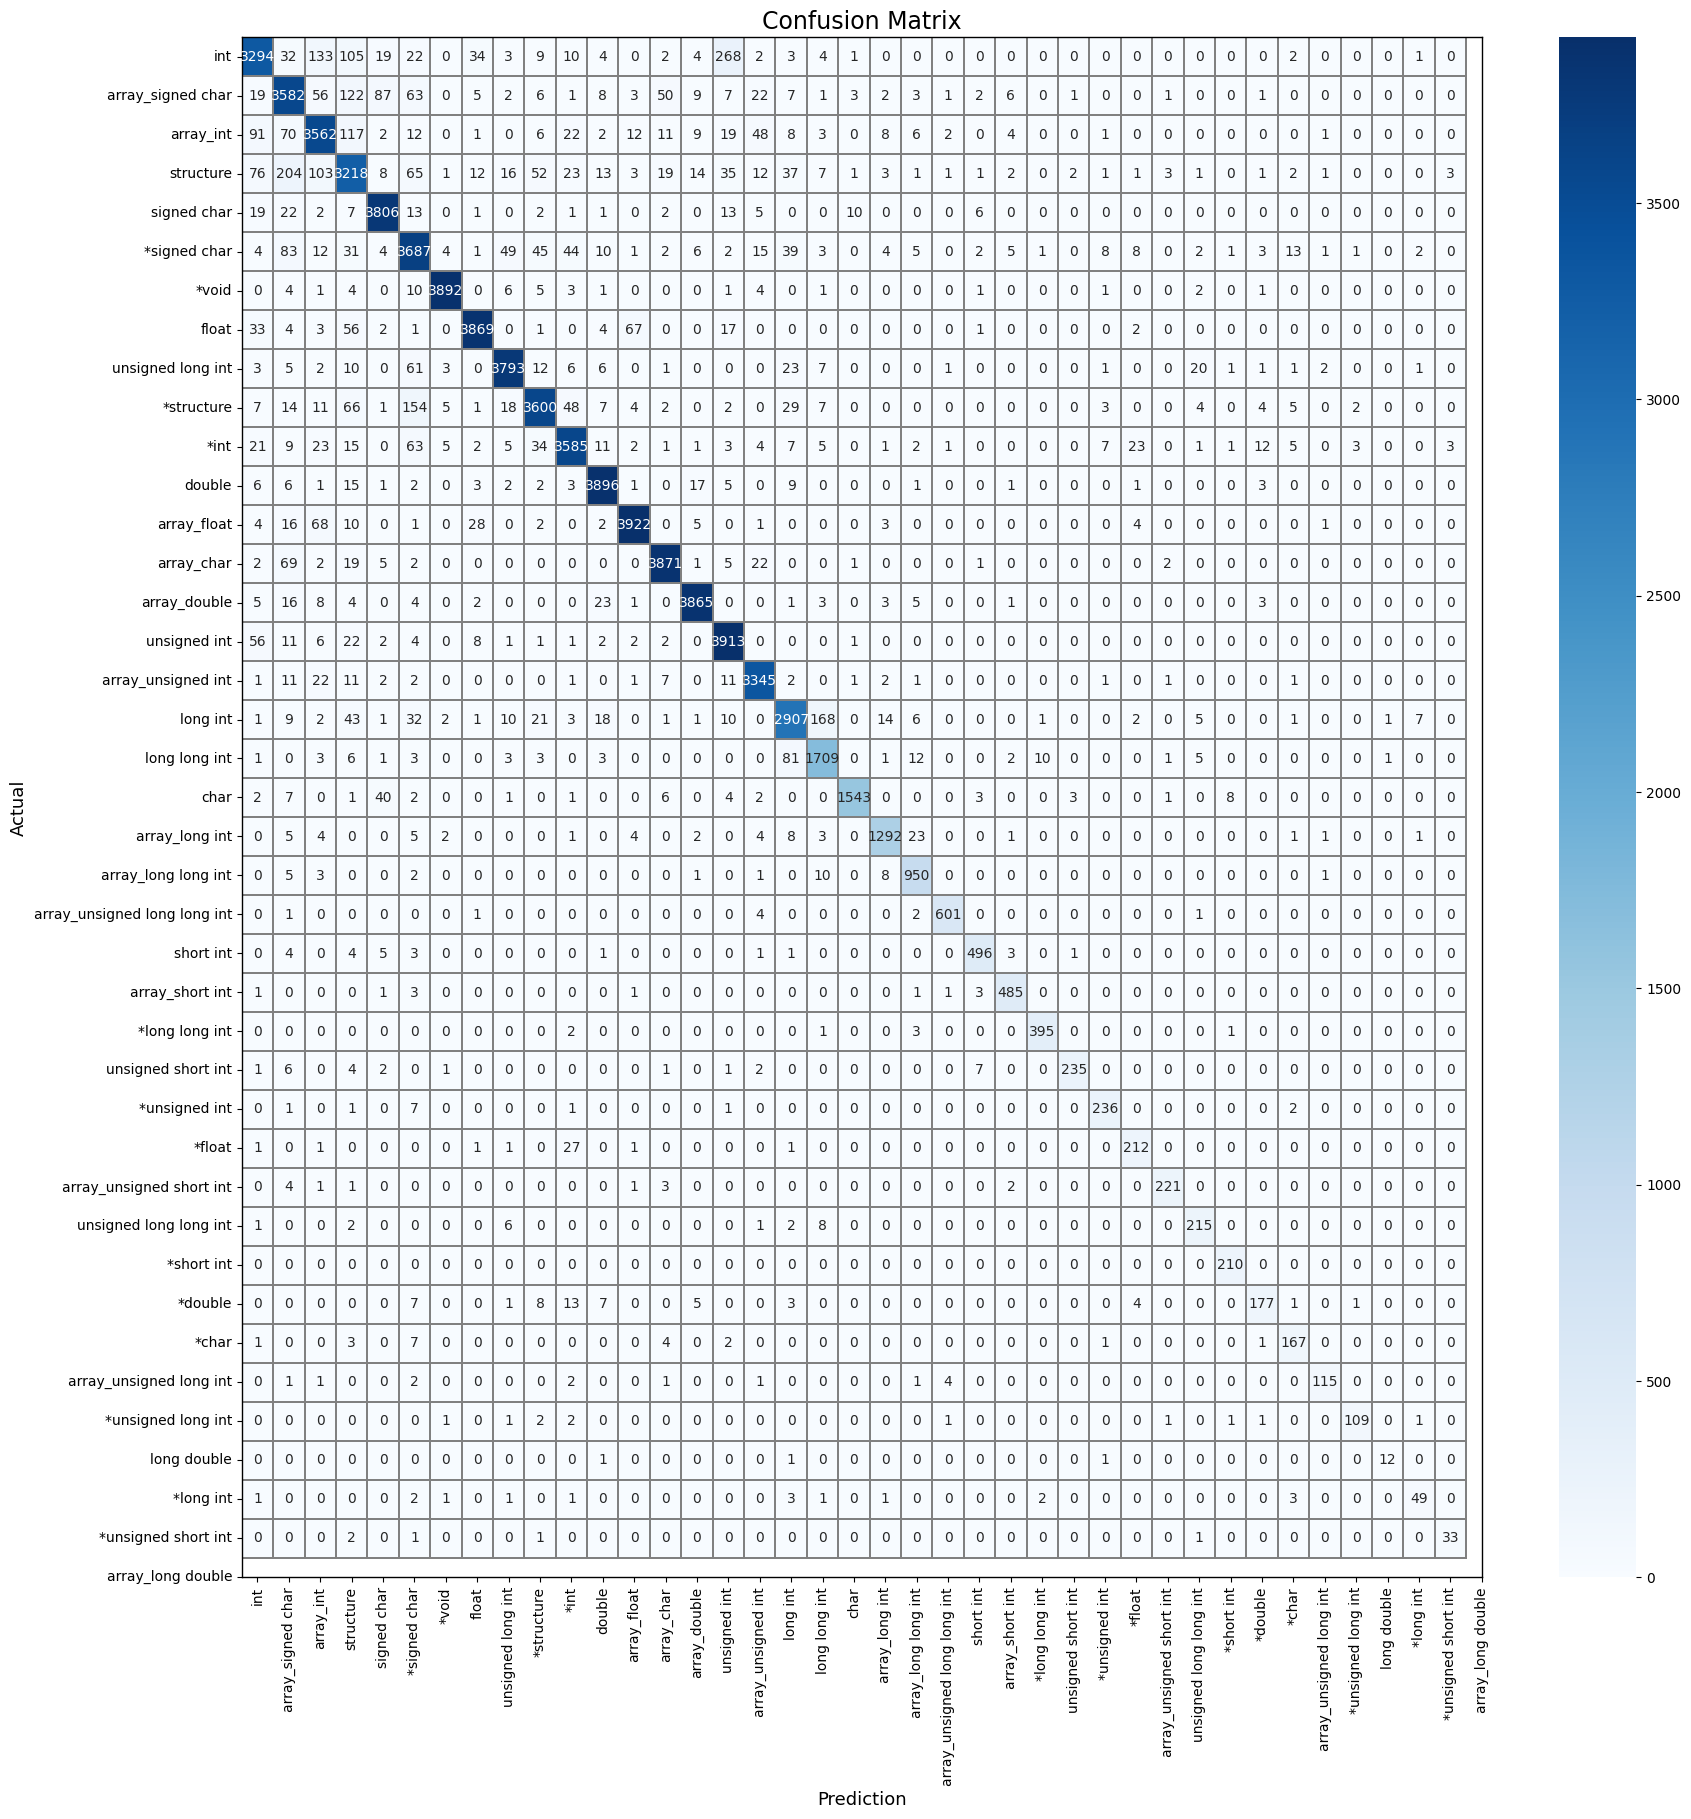

[0.86650007 0.86615887 0.88529887 0.82081367 0.96366629 0.88417266
 0.99108734 0.96363636 0.96281254 0.92236741 0.93652038 0.97460913
 0.96923267 0.96920381 0.98046677 0.93713328 0.96690273 0.90293524
 0.90279979 0.9689168  0.95739163 0.94857713 0.98282911 0.95201536
 0.96230159 0.97410604 0.93625498 0.9254902  0.84462151 0.95258621
 0.87398374 0.96997691 0.8137931  0.85641026 0.91633466 0.92372881
 0.82758621 0.77165354 0.85714286] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 12: 100%|█| 10743/10743 [1:15:30<00:00,  2.37it/s, loss=0.078


Training metrices:  {'accuracy': 0.9814714826537578, 'precision': 0.9814661895138862, 'recall': 0.9814714826537578, 'f1': 0.9814656230756759, 'loss': 0.056875067564253694}


Epoch 12: 100%|████| 2686/2686 [08:24<00:00,  5.33it/s, loss=0.228]


CONFUSION PER CLASS [0.86213003 0.83239125 0.89765936 0.78549696 0.97519182 0.88088845
 0.98908629 0.96846514 0.96011108 0.9334001  0.95616083 0.97686117
 0.97097885 0.95753185 0.98427992 0.96254031 0.97313869 0.92804654
 0.89208243 0.96736453 0.96017699 0.98059244 0.99672131 0.95568401
 0.97782258 0.98507463 0.95384615 0.92771084 0.76734694 0.98283262
 0.89361702 1.         0.77092511 0.89784946 0.8515625  0.95833333
 0.93333333 0.84615385 0.86842105] 0.9272258916694074


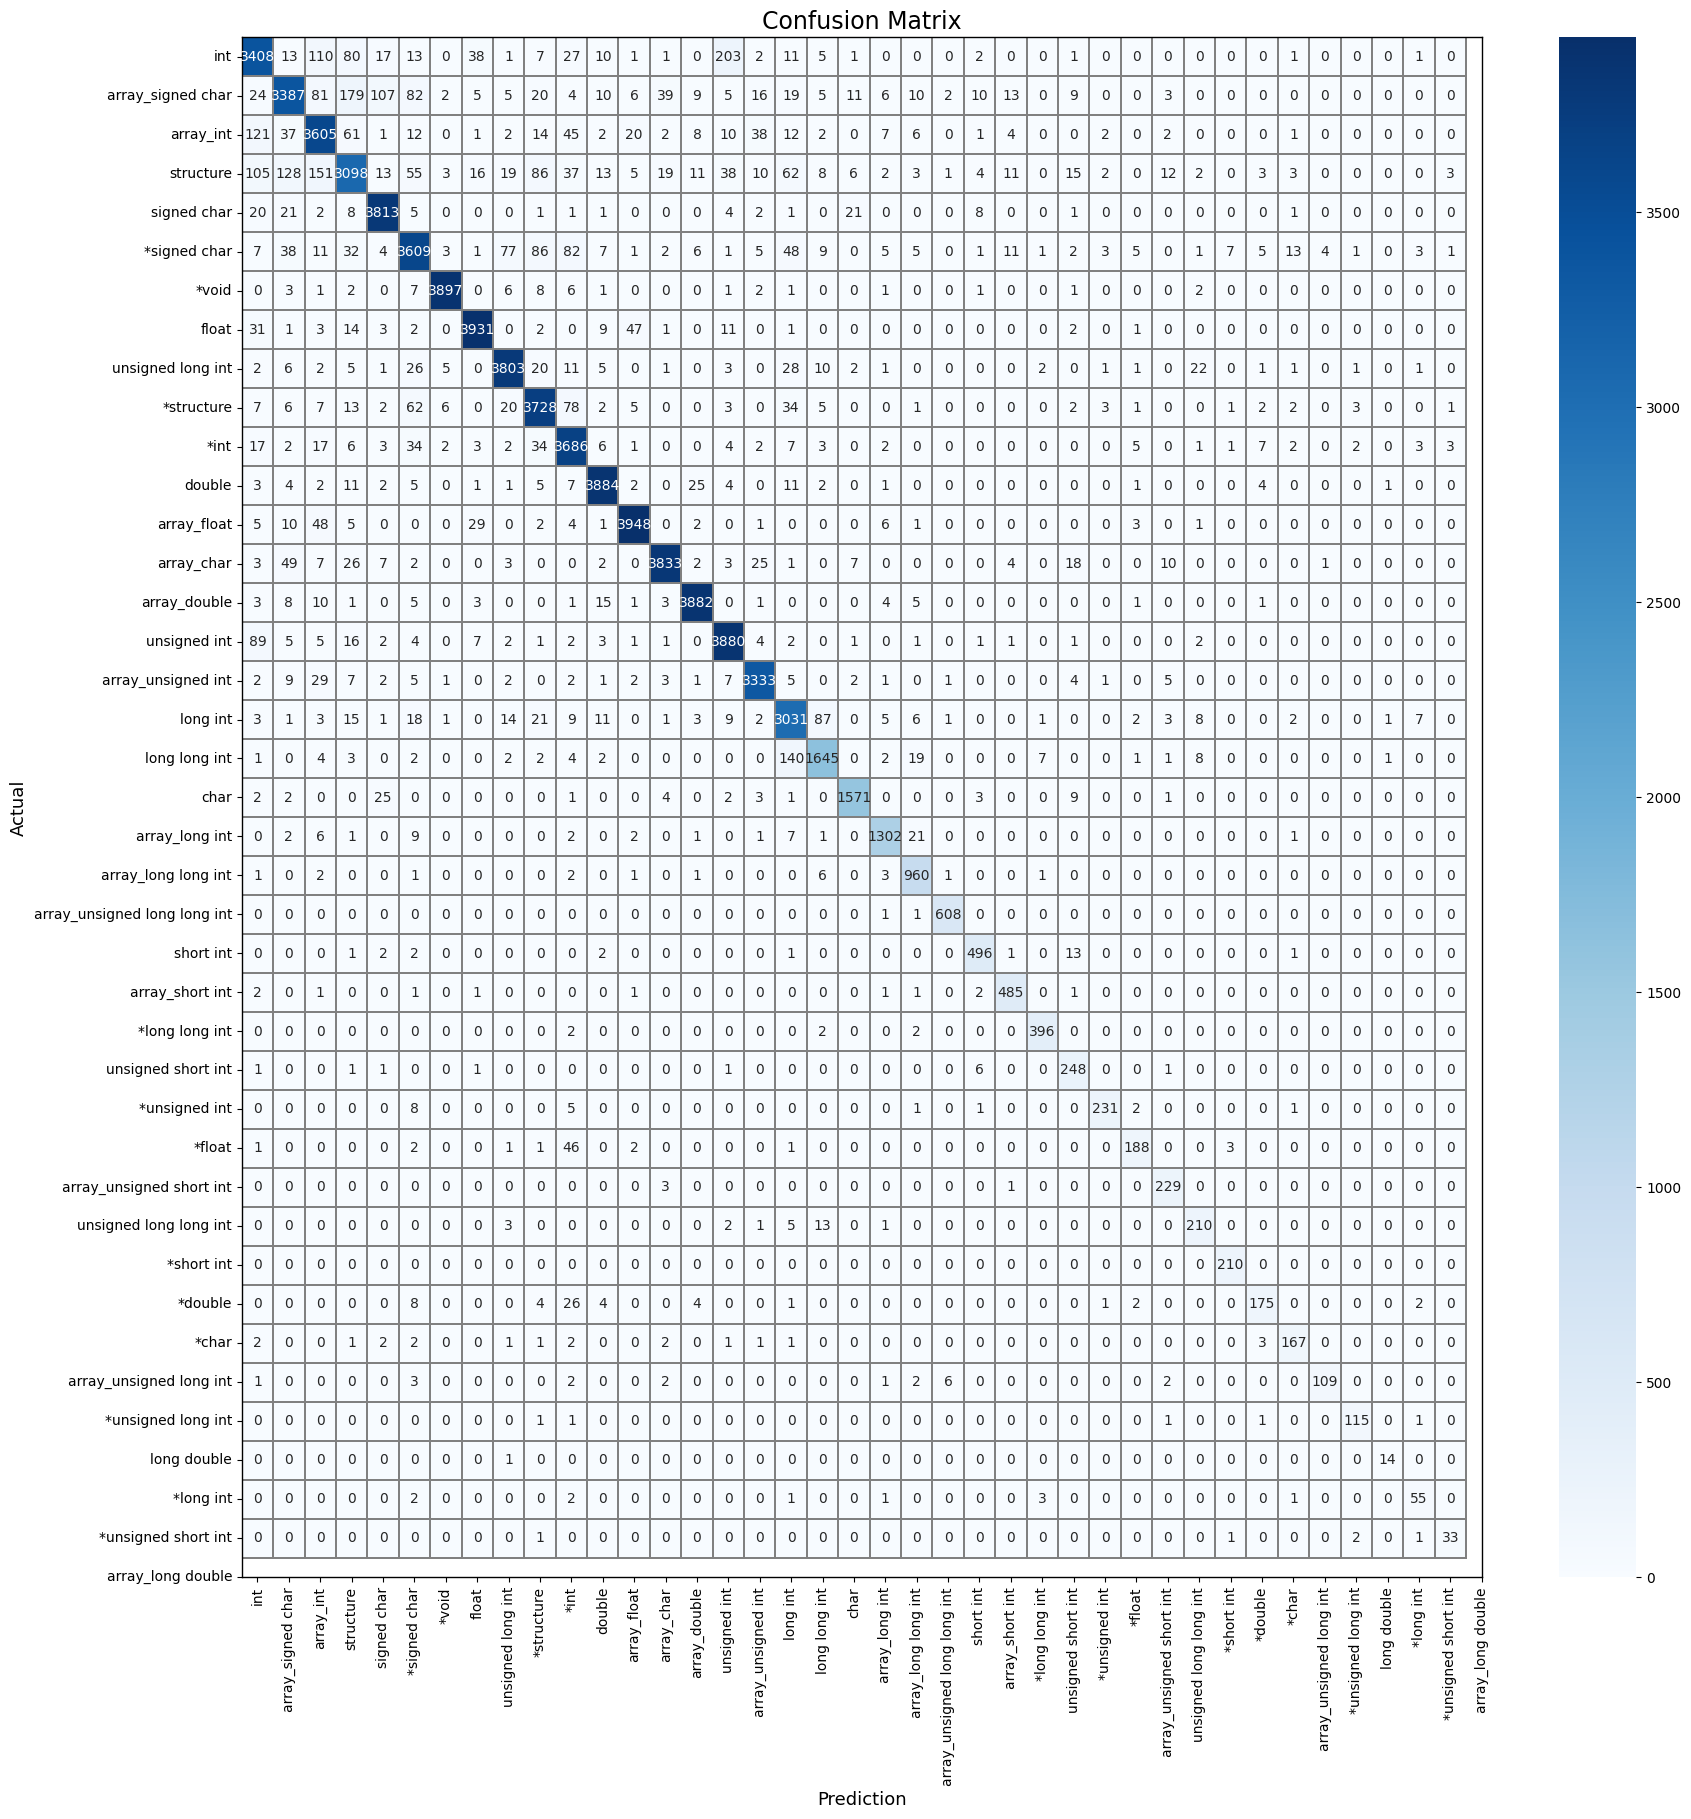

[0.87228052 0.86835021 0.8876031  0.82284197 0.963122   0.89298528
 0.99160305 0.97109684 0.95962655 0.92747854 0.92706237 0.97502197
 0.97337278 0.96792929 0.98290923 0.94369452 0.96974105 0.90504628
 0.90211132 0.96796057 0.96124031 0.9486166  0.98861789 0.94028436
 0.94449854 0.97416974 0.84497445 0.93711968 0.8209607  0.91053678
 0.85365854 0.96997691 0.81585082 0.87206266 0.90082645 0.94262295
 0.875      0.79136691 0.83544304] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 13: 100%|█| 10743/10743 [1:15:50<00:00,  2.36it/s, loss=0.013


Training metrices:  {'accuracy': 0.9836467448643952, 'precision': 0.9836422609660388, 'recall': 0.9836467448643952, 'f1': 0.9836430534555589, 'loss': 0.050108572857449026}


Epoch 13: 100%|██████| 2686/2686 [08:34<00:00,  5.22it/s, loss=0.268]


CONFUSION PER CLASS [0.88793322 0.84984026 0.88078646 0.78138473 0.9685422  0.90995608
 0.98654481 0.98275862 0.96212121 0.94541813 0.92090249 0.98188223
 0.9702337  0.97351324 0.98047667 0.95808532 0.97985401 0.8711356
 0.94465545 0.969809   0.96610169 0.96941896 0.99508197 0.96525097
 0.96975806 0.98258706 0.92692308 0.92369478 0.81632653 0.96566524
 0.89361702 0.98571429 0.72246696 0.89784946 0.84375    0.93333333
 0.8        0.8        0.86842105] 0.9213280483562419


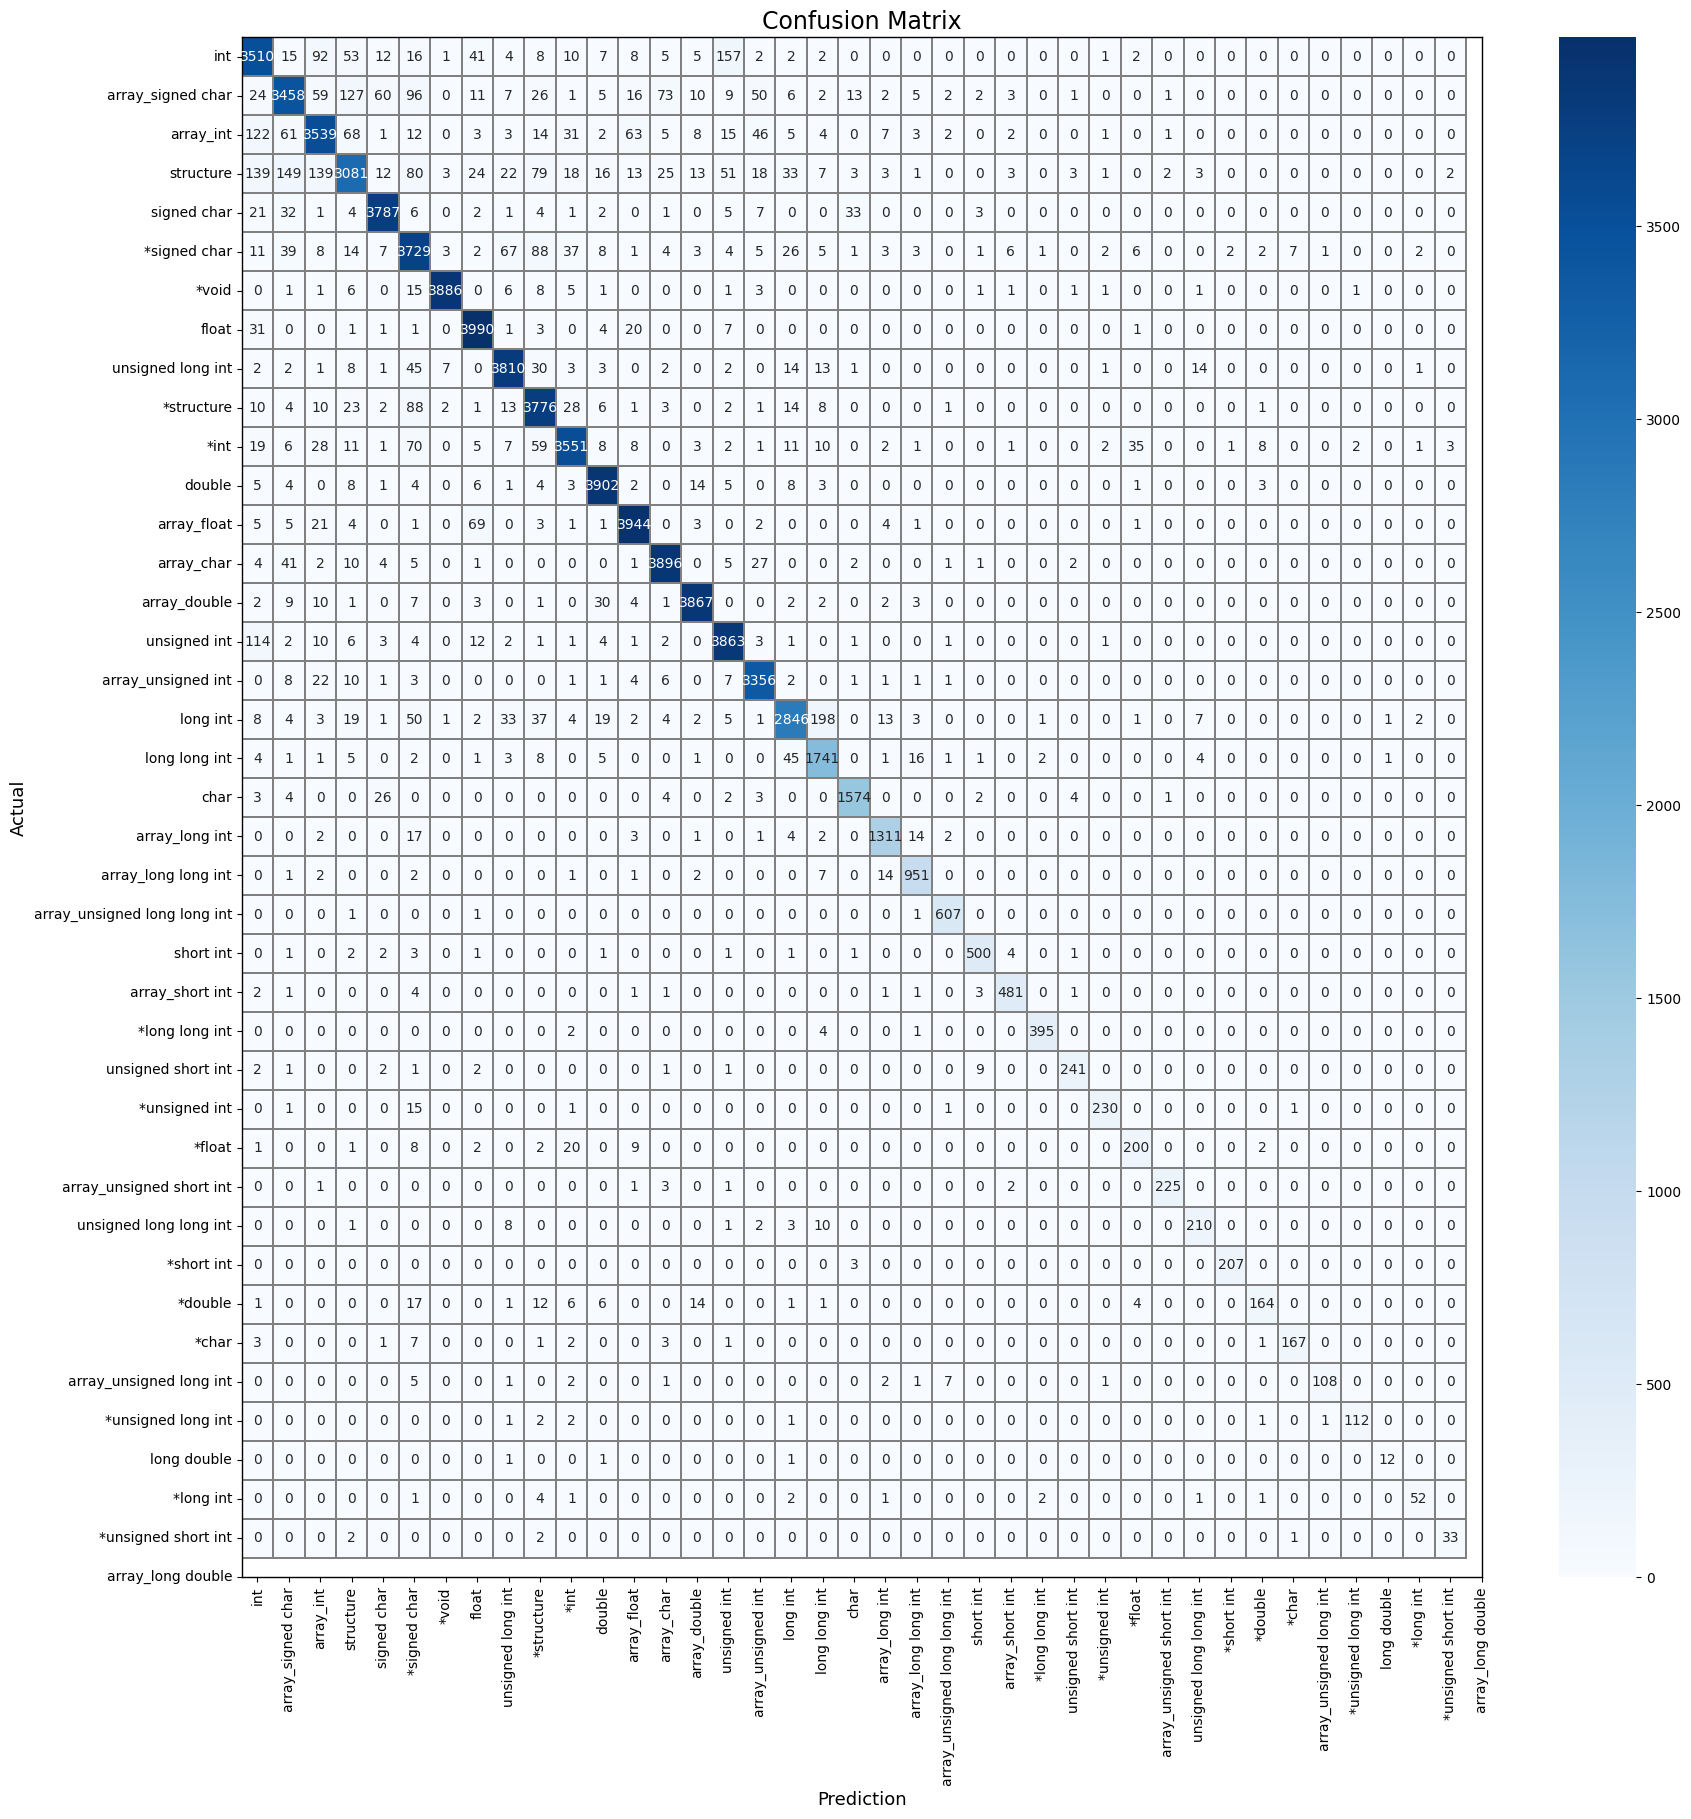

[0.87793897 0.87334259 0.8880803  0.83169119 0.96668794 0.88659058
 0.99107371 0.96856415 0.9582495  0.92481019 0.9359515  0.97476892
 0.96571988 0.96891321 0.98022814 0.94461426 0.9653387  0.90420969
 0.90160539 0.96683047 0.96255507 0.95722194 0.98220065 0.96061479
 0.96296296 0.98381071 0.93774319 0.93877551 0.80645161 0.97192225
 0.88421053 0.98571429 0.8        0.92265193 0.90756303 0.95319149
 0.82758621 0.84552846 0.86842105] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 14: 100%|█| 10743/10743 [1:17:24<00:00,  2.31it/s, loss=0.0902]


Training metrices:  {'accuracy': 0.9853131012226153, 'precision': 0.9853084976921218, 'recall': 0.9853131012226153, 'f1': 0.9853090239419103, 'loss': 0.04520792043918022}


Epoch 14: 100%|██████| 2686/2686 [08:34<00:00,  5.22it/s, loss=0.223]


CONFUSION PER CLASS [0.85479383 0.86445264 0.8852663  0.80142024 0.97519816 0.90483163
 0.98984772 0.97857671 0.95531431 0.94365139 0.93386929 0.97937626
 0.97170972 0.96175    0.98631179 0.96129993 0.96933411 0.90603
 0.91382114 0.94704433 0.96683861 0.96024465 0.98032787 0.96917148
 0.97983871 0.98507463 0.91923077 0.93172691 0.8        0.96137339
 0.85042735 1.         0.81497797 0.88172043 0.80314961 0.91666667
 0.73333333 0.84615385 0.92105263] 0.9206463677793616


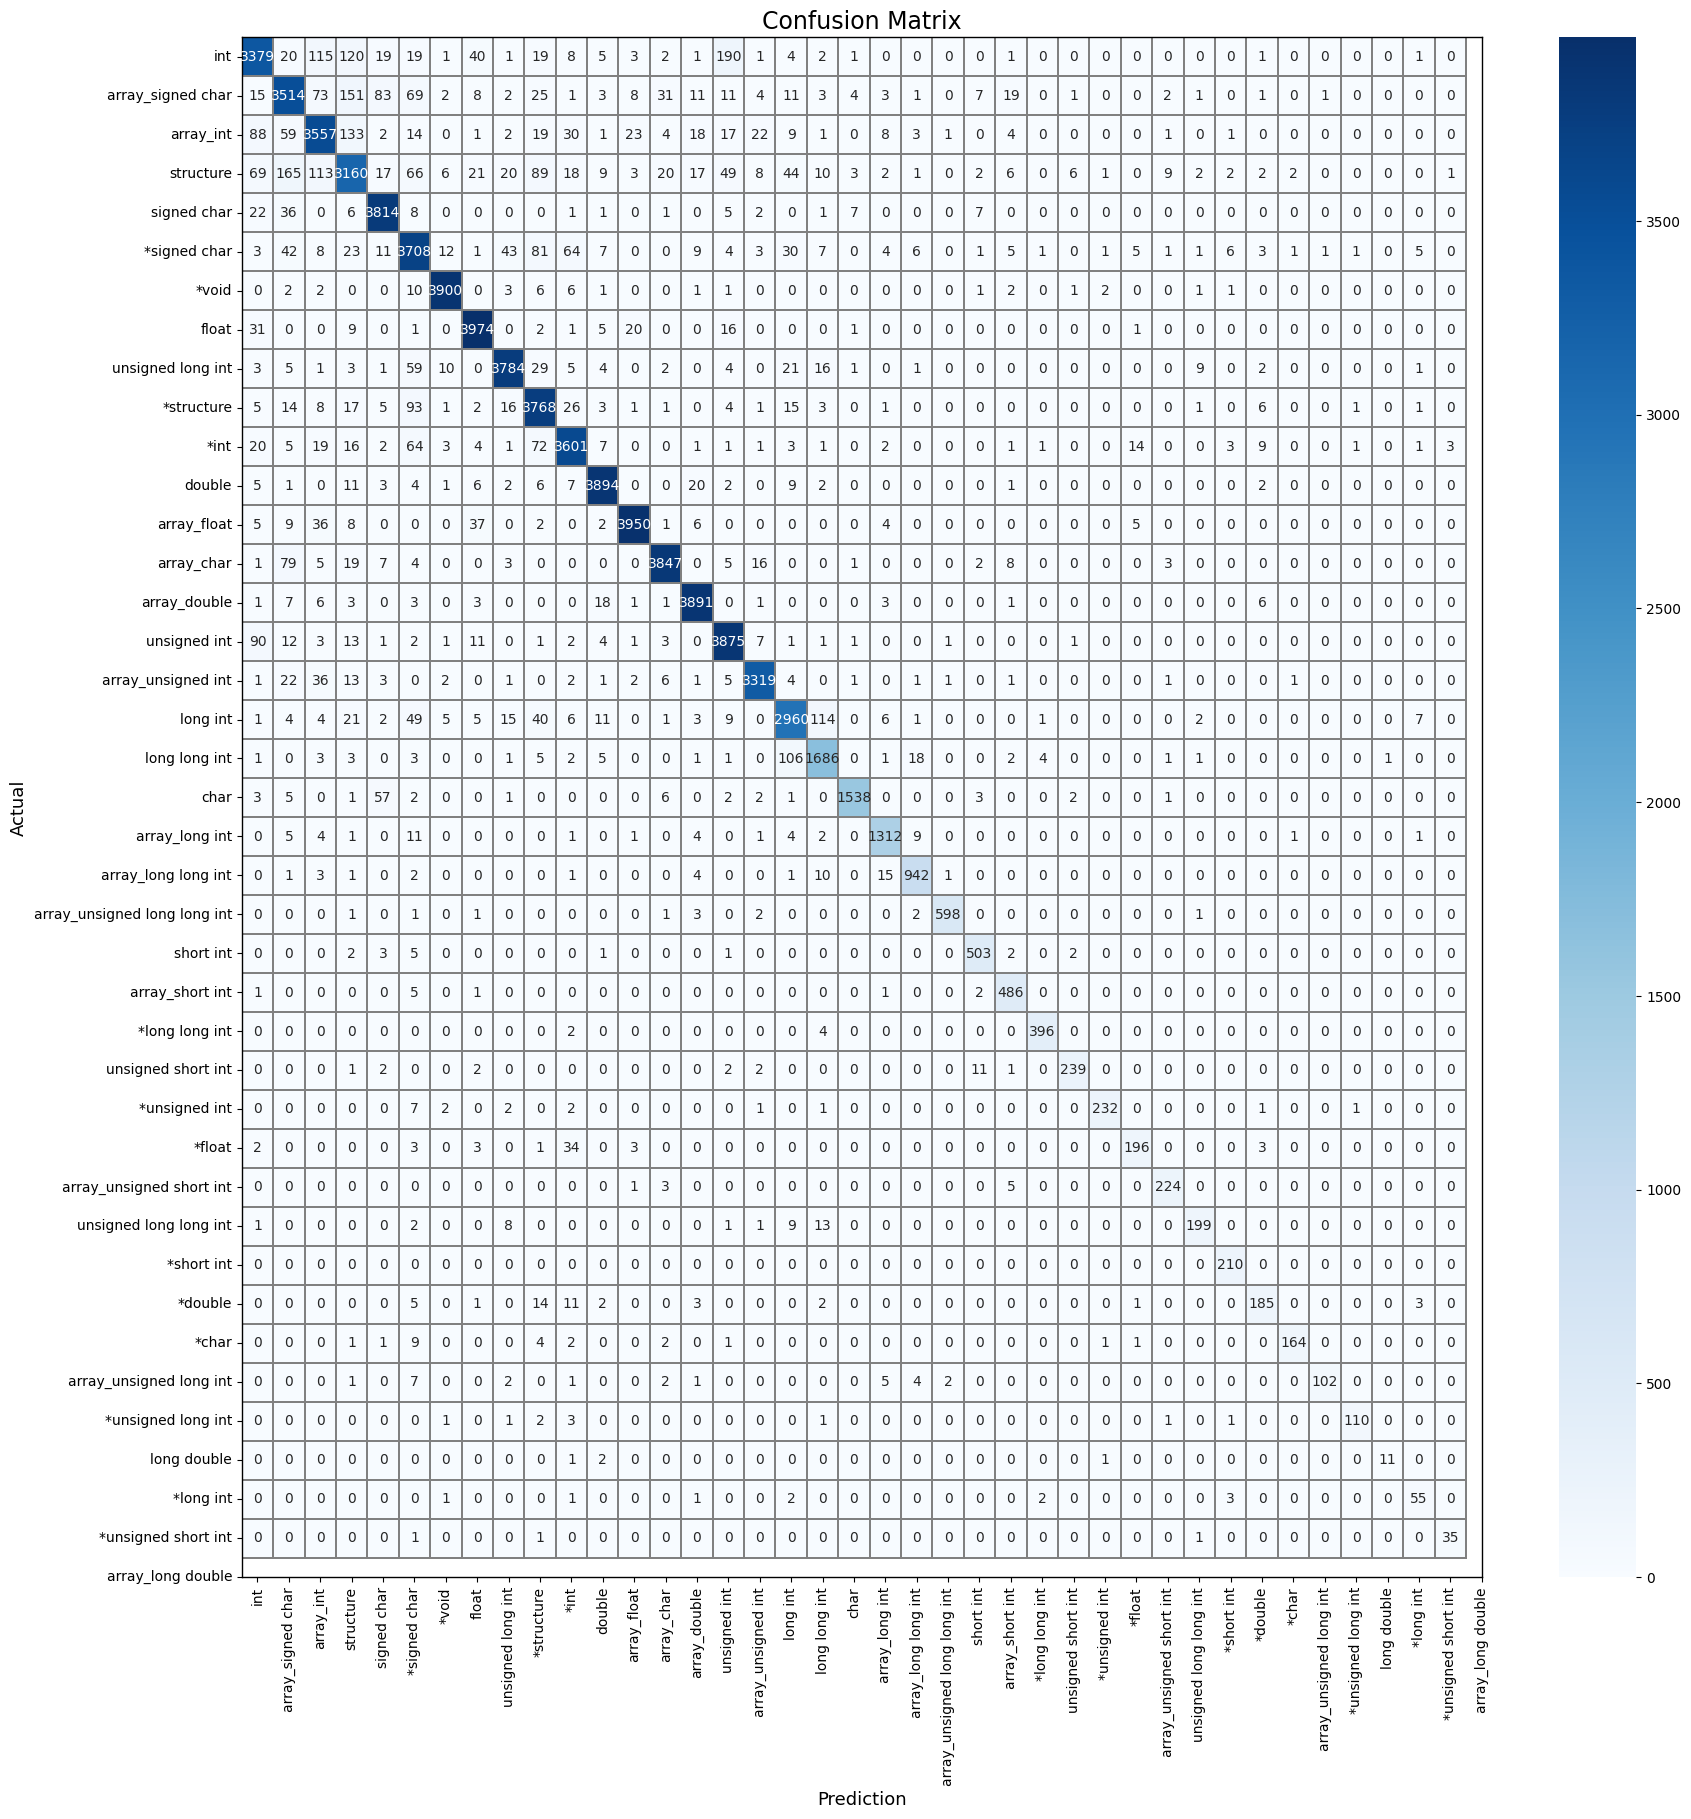

[0.87766234 0.87066402 0.88769653 0.82280953 0.96022155 0.88984881
 0.98884381 0.97140064 0.96174863 0.92138403 0.93593242 0.97814619
 0.97748082 0.96975044 0.97997733 0.94087653 0.9735993  0.91062913
 0.9052349  0.96668762 0.96328928 0.95634518 0.98517298 0.95085066
 0.93371758 0.98141264 0.93359375 0.95277207 0.83760684 0.93920335
 0.8785872  0.9610984  0.82589286 0.92394366 0.88311688 0.94017094
 0.81481481 0.78571429 0.90909091] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int',

Epoch 15: 100%|█| 10743/10743 [1:39:25<00:00,  1.80it/s, loss=0.00526


Training metrices:  {'accuracy': 0.9866039843604543, 'precision': 0.9866011879198957, 'recall': 0.9866039843604543, 'f1': 0.9866012746833026, 'loss': 0.04051096272982137}


Epoch 15: 100%|█████| 2686/2686 [13:56<00:00,  3.21it/s, loss=0.0546]


CONFUSION PER CLASS [0.87117186 0.86823992 0.88473986 0.79325216 0.97289003 0.87869173
 0.98680203 0.97537552 0.9540404  0.94189832 0.94190871 0.9791195
 0.97491392 0.96702473 0.98580482 0.958323   0.98422897 0.85981022
 0.95447154 0.97844828 0.95431098 0.97043833 0.99180328 0.96146435
 0.98790323 0.99004975 0.94230769 0.94779116 0.75918367 0.96566524
 0.94042553 1.         0.84581498 0.90322581 0.8828125  0.95833333
 0.8        0.828125   0.89473684] 0.9291165945557481


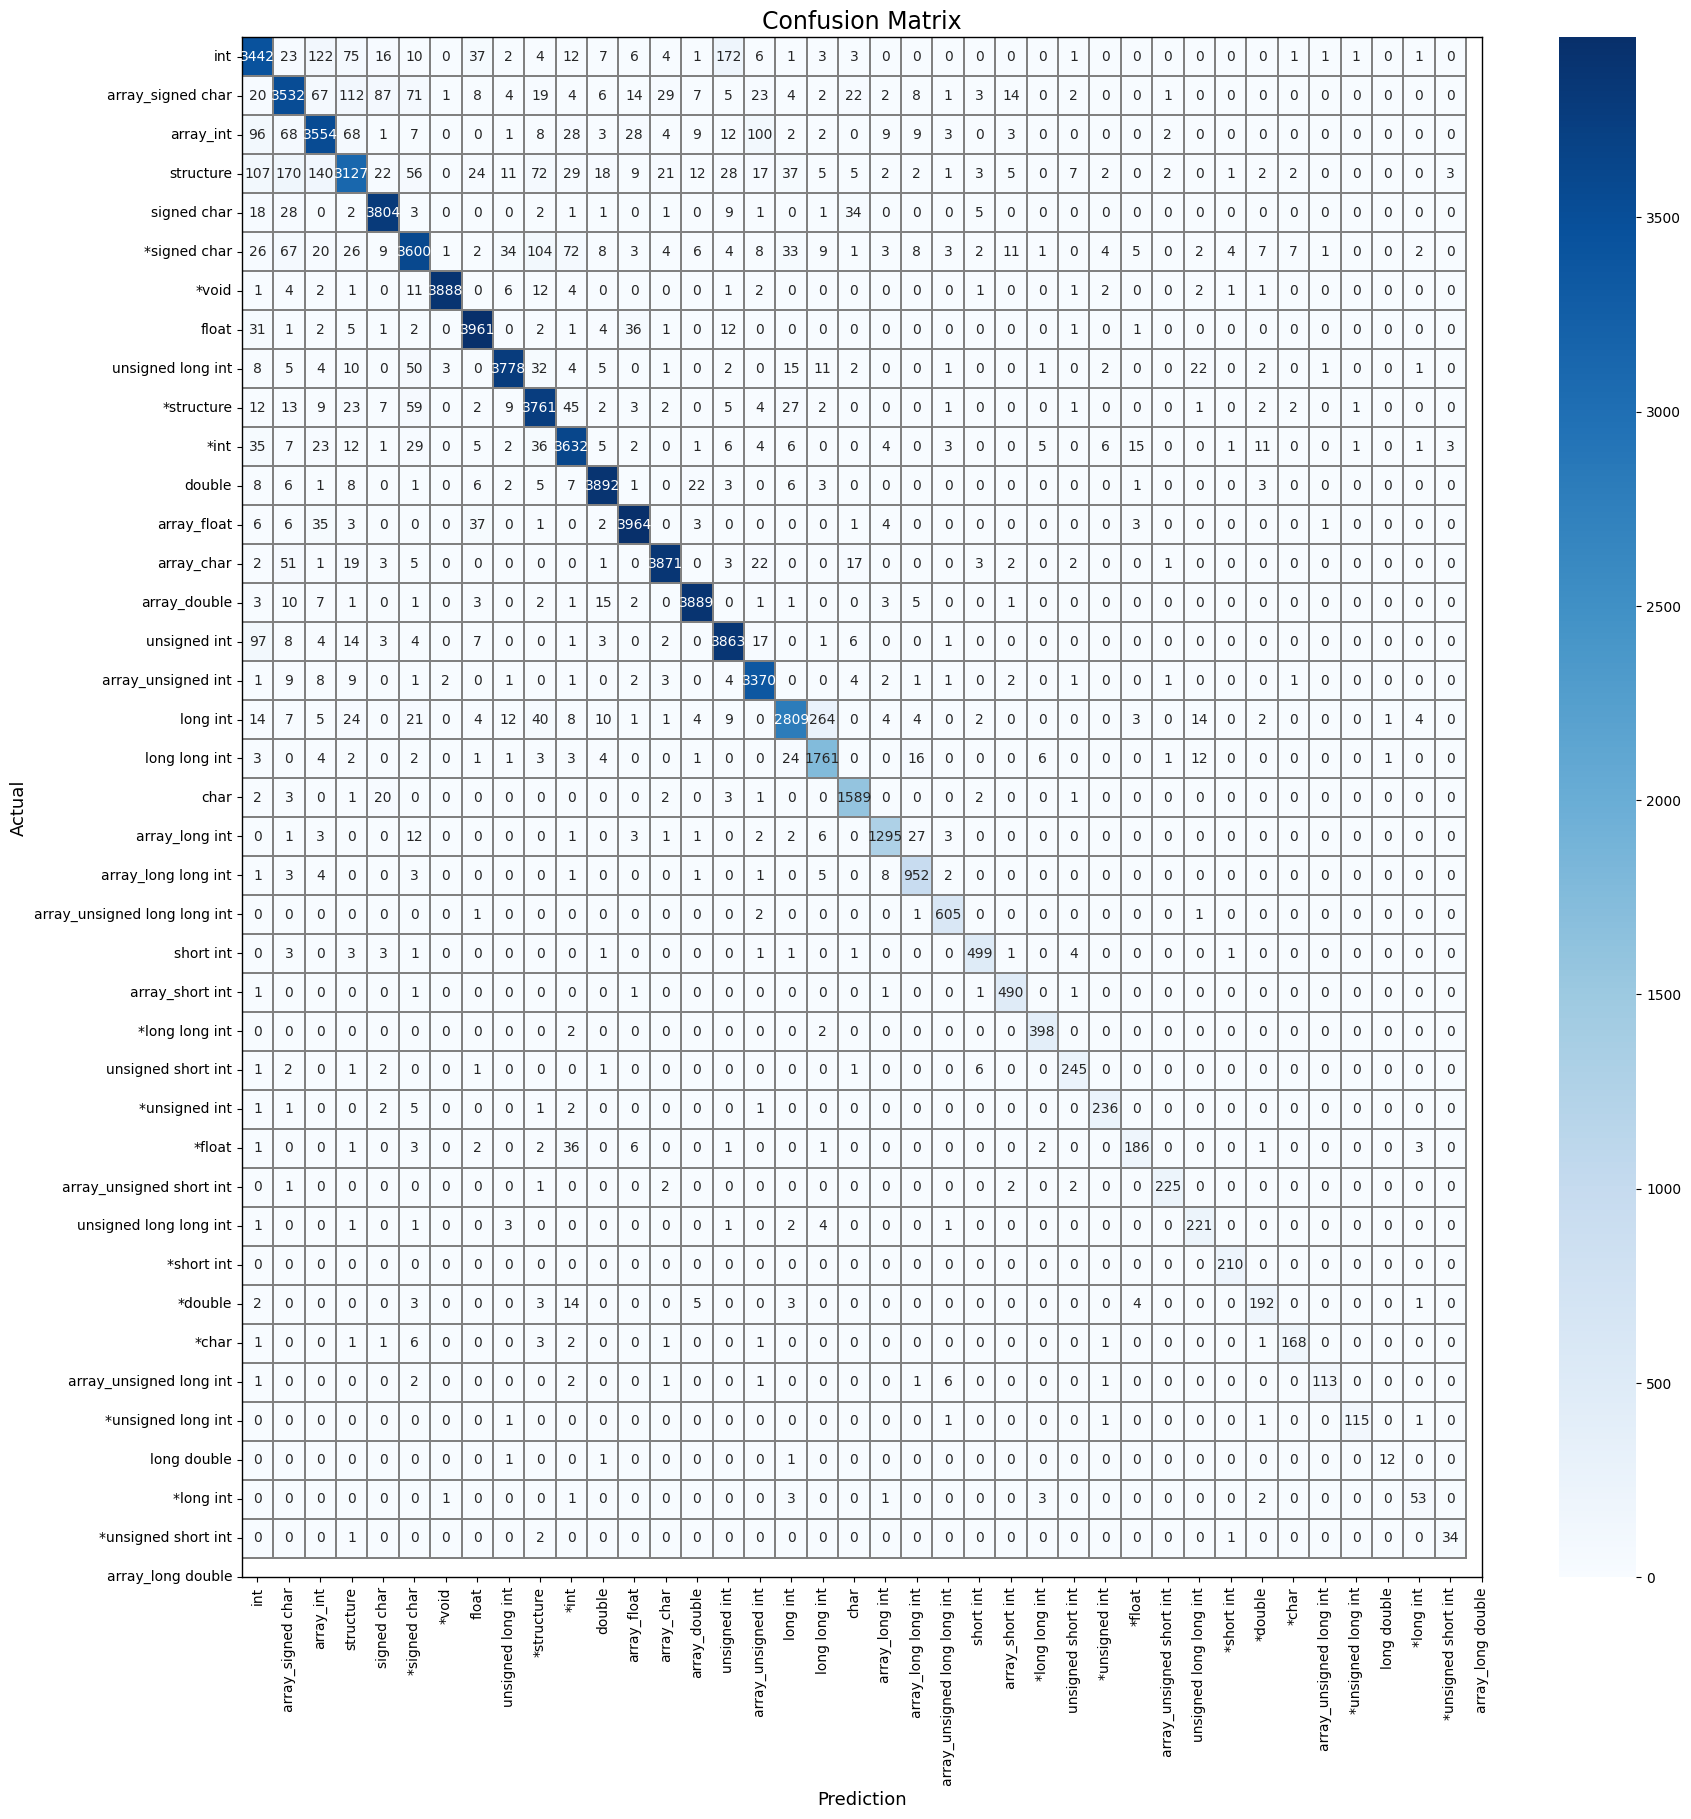

[0.87216521 0.87242188 0.88496016 0.83475707 0.96401419 0.8925251
 0.99234303 0.97059544 0.96525294 0.9277257  0.93487773 0.97739829
 0.97311894 0.97334674 0.98368534 0.94519207 0.96162077 0.89974375
 0.89686784 0.96012085 0.96103896 0.94491315 0.97345133 0.9541109
 0.95423564 0.97310513 0.92627599 0.93650794 0.80345572 0.96566524
 0.86666667 0.97902098 0.84581498 0.91553134 0.92244898 0.96638655
 0.82758621 0.80916031 0.87179487] ['int', 'array_signed char', 'array_int', 'structure', 'signed char', '*signed char', '*void', 'float', 'unsigned long int', '*structure', '*int', 'double', 'array_float', 'array_char', 'array_double', 'unsigned int', 'array_unsigned int', 'long int', 'long long int', 'char', 'array_long int', 'array_long long int', 'array_unsigned long long int', 'short int', 'array_short int', '*long long int', 'unsigned short int', '*unsigned int', '*float', 'array_unsigned short int', 'unsigned long long int', '*short int', '*double', '*char', 'array_unsigned long int', '

Epoch 16:  63%|█▎| 6726/10743 [1:04:02<38:14,  1.75it/s, loss=0.0949]


KeyboardInterrupt: 

In [23]:
EPOCHS = 30


global_metrices = []
v_global_metrices = []


for ecpoch in range(EPOCHS):
    
    train_loop = tqdm(train_loader, leave=True)
    model.train()
    metrices,prediction_s, ground_truth_s  = training_loop(model ,train_loop, is_training = True)
    print('Training metrices: ',metrices)
    global_metrices.append(metrices)
    
    with torch.no_grad():
        model.eval()
        validation_loop = tqdm(validation_loader, leave=True)
        v_metrices, v_prediction_s, v_ground_truth_s  = training_loop(model ,validation_loop, is_training = False)
        plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)
        print('v_metrices: ',v_metrices)
        v_global_metrices.append(v_metrices)
    plot_graph(global_metrices,v_global_metrices , label = EXPERIMENT_NAME)
#     break
    print('SAVING MODEL @ ',MODEL_SAVE_PATH +EXPERIMENT_NAME)
    model.save_pretrained(MODEL_SAVE_PATH +EXPERIMENT_NAME)


In [ ]:
model.save_pretrained( MODEL_SAVE_PATH  + EXPERIMENT_NAME )

In [ ]:
print('Alhamdulillah')